# Perkenalan

___
Milestone 2

Nama: Fadhiil Dzaki Mulyana<br>
Batch: HCK-21

Notebook ini akan digunakan untuk melakukan analisis  mengenai hal hal yang berhubungan kecenderungan orang untuk melakukan deposit dan membangun model machine learnning yang dapat memprediksi orang-orang yang cenderung berdeposit.
___



**Link App:**<br>
[Deposit Predictor](https://huggingface.co/spaces/fadhiil23/Bank_Deposit_Predictor)

**Dataset Description:**<br>
Source: [Kaggle | Bank Marketing Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset/data)

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ("yes") or not ("no") subscribed.

| #| Attribute| Description | Type| Values|
|--|----------|-------------|-----|-------|
| 1| age| Age of the client| Numeric | |
| 2| job| Type of job| Categorical |"admin.", "technician", "services", "management", "retired", "blue-collar", "unemployed", "entrepreneur", "housemaid", `"unknown"`, "self-employed", "student" |
| 3| marital| Marital status | Categorical | "married", "single", "divorced" (note: "divorced" includes divorced and widowed)|
| 4| education| Education level| Categorical | "secondary", "tertiary", "primary", `"unknown"`|
| 5| default| Has credit in default? | Binary | "no", "yes"|
| 6| balance| Average yearly balance, in euros | Numeric| |
| 7| housing| Has housing loan?| Binary | "yes", "no"|
| 8| loan | Has personal loan? | Binary | "no", "yes"|
| 9| contact| Contact communication type | Categorical | `"unknown"`, "cellular", "telephone"|
| 10 | day| Last contact day of the month| Numeric| |
| 11 | month| Last contact month of the year | Categorical | "jan", "feb", "mar", ..., "nov", "dec"|
| 12 | duration | Last contact duration, in seconds| Numeric| |
| 13 | campaign | Number of contacts performed during this campaign for this client| Numeric| |
| 14 | pdays| Number of days since the client was last contacted from a previous campaign | Numeric| `-1 if not contacted before` |
| 15 | previous | Number of contacts performed before this campaign for this client| Numeric| |
| 16 | poutcome | Outcome of the previous marketing campaign | Categorical | `"unknown"`, "other", "failure", "success" |
| 17 | deposit (target) | Has the client subscribed to a term deposit? | Binary | "yes","no"|

**Background:**
Portuguese banking institutions menghadapi tantangan besar dalam meningkatkan efektivitas kampanye pemasaran mereka, terutama dalam mempromosikan produk deposito berjangka. Salah satu masalah utama adalah rendahnya tingkat konversi dari upaya pemasaran langsung, di mana banyak kontak dengan nasabah tidak menghasilkan langganan deposito dan menyebabkan bank cenderung menyia-nyiakan sumber daya dengan menargetkan nasabah yang tidak tertarik.

**Problem Statement:**
Membangun Machine Learning Classification model dengan presisi diatas 70% untuk memprediksi seseorang cenderung berdeposit dalam waktu 1 minggu dengan memahami perilaku calon nasabah melalui data Bank Marketing. Prediksi yang akurat dapat meningkatkan efisiensi kampanye pemasaran, menargetkan klien yang lebih mungkin merespon secara positif, dan pada akhirnya meningkatkan tingkat keberhasilan penjualan serta mengurangi biaya pemasaran.

**Problem Breakdown:**

# Import Libraries

## Library

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# statistik
from scipy.stats import chi2_contingency, kendalltau

# prep
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluasi
from sklearn.metrics import precision_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Tuning
from sklearn.model_selection import RandomizedSearchCV

# saving
import pickle

# ignore warning
import warnings
warnings.filterwarnings('ignore')

## Function

In [2]:
# Overview
# overview
def check_overview(df):
    '''
    df_overview adalah fungsi yang digunakan untuk melihat informasi seputar dataset.

    Argumen:
    df = dataset yang digunakan.

    Output:
    Informasi overall dataset, missing value, duplicated value dan jumlah unique value setiap kolom.
    '''
    # df overview
    print(df.info())
    

    # cek missing value
    print(f"\nmissing values: {round(((df.isna().sum().sum())/len(df))*100, 2)}% \n{df.isna().sum()[df.isna().sum()>0]}")

    # cek duplicated value
    print(f"\nduplicated values: {round(((df.duplicated().sum())/len(df))*100,2)}% \n{df.duplicated().sum()}\n")

    # cek nama kolom & jumlah unique value
    for col in df:
        print(f'{col}-#nunique: {df[col].nunique()}')

# fungsi cek outlier
def check_outlier(df, kolom):
    '''
    argumen:
    df = dataframe
    kolom = kolom numerik [list]
    multiplier = pengkali dalam metode IQR (1.5 / 3)
    '''
    # mengecek deskriptif stats
    deskriptif = check_deskriptif(df,kolom)

    # batas atas
    upper_fence = []
    #batas bawah
    lower_fence = []
    # persentase outlier
    percent_outlier = []

    # looping untuk mengisi list kosong
    for i in kolom:
        # bentuk distribusi
        bentuk_dist = deskriptif['jenis_skewness'][i]
        # besar skewness
        besar_skew = deskriptif['skewness'][i]

        # jika bentuk distribusi skew
        if bentuk_dist == 'skewed':
            # jika outlier kecil
            if -1 < besar_skew < 1:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                
                # menghitung boundaries
                batas_bawah = Q1-1.5*IQR
                batas_atas = Q3+1.5*IQR
            # jika outlier extreeme
            else:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                # menghitung boundaries
                batas_bawah = Q1-3*IQR
                batas_atas = Q3+3*IQR

        # jika bentuk distribusi normal
        else:
            # rata2 dan st. deviasi
            avg = df[i].mean()
            std = df[i].std()

            # boundaries
            batas_atas = avg + 3*std
            batas_bawah = avg - 3*std

        # menghitung persentase outlier
        persentase_out = ((len(df[df[i] > batas_atas]) / len(df) * 100) + (len(df[df[i] < batas_bawah]) / len(df) * 100))
        persentase_out = round(persentase_out,2)

        # boundaries adn percentage add
        lower_fence.append(batas_bawah)
        upper_fence.append(batas_atas)
        percent_outlier.append(persentase_out)

    # convert to df
    outlier = pd.DataFrame({
        'batas_atas': upper_fence,
        'batas_bawah': lower_fence,
        'persentase' : percent_outlier},
        index=kolom
        )
    # mengembalikan outlier
    return outlier

# fungsi cek deskriptif stats
def check_deskriptif(df, kolom):
    '''
    Fungsi ini digunakan untuk mengetahui statistik deskriptif.

    Argumen:
    - df = DataFrame
    - kolom = List dari kolom numerik

    Return:
    - DataFrame yang berisi deskriptif statistik data.
    '''
    # deskriptif stats
    deskriptif = df[kolom].describe().T

    # List untuk menyimpan nilai
    skewness_values = []
    jenis_skewness = []

    # Loop untuk menghitung skewness dan kurtosis setiap kolom
    for i in kolom:
        # Menghitung skewness
        skew = df[i].skew()
        skewness_values.append(skew)
        
        # Menentukan jenis skewness
        if -0.5 <= skew <= 0.5:
            jenis_skewness.append('normal')
        else:
            jenis_skewness.append('skewed')

    # Membuat kolom baru dalam deskriptif
    deskriptif['skewness'] = skewness_values
    deskriptif['jenis_skewness'] = jenis_skewness

    return deskriptif

# stats
# fungsi crosstab
def crosstable(df,a,b):
    '''
    fungsi ini digunakan untuk membuat cross tabulation dari 2 variable berbeda

    argumen:
    df = dataframe yang digunakan
    a = variable yang ingin dibandingkan
    b = variable pembanding

    output:
    cross table
    '''
    # cross tabulation
    chi_tab = pd.crosstab(df[a], df[b])
    # mengembalikan chi_tab
    return chi_tab

# fungsi chi2_contigency
def uji_chisquare(df,kolom_1,kolom_2):
    '''
    fungsi ini digunakan untuk melakukan perhitungan statistika chisquared

    argumen:
    df = dataframe yang digunakan
    a = variable yang ingin dibandingkan
    b = variable pembanding

    Output:
    chi-squared statistic, p-value, degrees of freedom, expected frequencies
    '''
    # chi2 calculation
    chi2, p_value, dof, expected = chi2_contingency(crosstable(df,kolom_1,kolom_2))

    if p_value < 0.05:
        print(f'H0 berhasil ditolak: {kolom_1} berpengaruh terhadap {kolom_2}\n')
    else:
        print(f'H0 gagal ditolak: {kolom_1} TIDAK berpengaruh terhadap {kolom_2}\n')
    
    # mengembalikan nilia nilai hasil kalkulasi
    return chi2, p_value, dof

# fungsi uji kendall
def uji_kendall(df,kolom_1, kolom_2):
    '''
    argumen:
    df = dataset
    kolom_1 = kolom fitur
    kolom_2 = kolom target
    '''    
    #uji stats
    stat, p_value = kendalltau(df[kolom_1],df[kolom_2])

    # hasil
    print(f'koefisien corr = {stat}')
    print(f'pvalue = {p_value}\n')

    if p_value < 0.05:
        print(f'H0 berhasil ditolak: {kolom_1} berkorelasi dengan {kolom_2}\n')
    else:
        print(f'H0 gagal ditolak: {kolom_1} TIDAK berkorelasi dengan {kolom_2}\n')

    return stat, p_value

# visualization
# fungsi boxplot
def plot_boxplot(df,kolom):
    for i in range(0,len(kolom)):
        plt.subplot(1,len(kolom),i+1)
        sns.boxplot(y=df[kolom[i]])
        plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
        plt.title(kolom[i])
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

# evaluasi
def performance_report(all_reports, crossvals, y_train, y_pred_train, y_test, y_pred_test, name):
  score_reports = {
      'train - precision' : precision_score(y_train, y_pred_train),
      'train - precision - cv' : crossvals.mean(),
      'train - accuracy' : accuracy_score(y_train, y_pred_train),
      'test - precision' : precision_score(y_test, y_pred_test),
      'test - accuracy_score' : accuracy_score(y_test, y_pred_test),
  }
  all_reports[name] = score_reports
  return all_reports

# Data Loading

## Load Data

In [3]:
df = pd.read_csv('bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# save
df_org = df.copy()

In [5]:
# load
df = df_org.copy()

## Overview

In [6]:
check_overview(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None

missing values: 0.0% 
Series([], dtype: int64)

duplicated values: 0.0% 
0

age-#nunique: 76


**Overview:**
- Dataset memiliki 17 kolom dan 11161 baris, dengan detail sebagai berikut:
    - Numerik: 'age', 'balance', 'duration', 'campaign', 'pdays', 'previous'.
    - Kategorik:'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'deposit'.
- Nama kolom sudah konsisten, tidak ada white_space, dan cukup sesuai dengan deskripsi kolom.
- Tipe data sudah sesuai dengan jenis kolom. `perlu diperhatikan karena 'day' merupakan tanggal (hari) dalam bulan sehingga dtype-nya adalah integral, walaupun merupakan kolom kategorik`.
- Tidak terdeteksi adanya missing value, namun nampaknya ada beberapa non-standard missing value, seperti "unknown" dan "-1" yang `perlu dicek ulang untuk memastikan apakah value-value tersebut merupakan missing value atau bukan`.
- Tidak ada duplicated value.
- Dilihat dari missing value
- Melihat jumlah unique value setiap kolom, didapatkan bahwa 'day' merupakan kolom kategorik dengan high cardinality karena memiliki terlalu banyak unique value. `perlu dilakukan handling cardinality untuk 'day'`.
- Pada kolom 'job' terdapat value yang diakhiri dengan ".", seperti "admin.". "." yang `akan dihapus untuk menjaga kerapihan data`.

## Feature Engineering EDA
Feature engineering ini dimaksudkan untuk merapihkan data (merapihkan value, mengubah nama kolom, dll) tanpa mengurangi data.

### High Cardinality Handling

'day' merupakan kolom dengan cardinality yang tinggi. Untuk mengatasinya, akan dibuat kolom 'week' yang mengelompokan data per tanggal (hari) menjadi per minggu.

In [7]:
# inisiasi list untuk menampung week
week = []

# loop deteksi minggu berdasarkan tanggal
for i in df['day']:
    # kondisi tanggal 1-7
    if i <= 7:
        # add minggu ke-1 ke list
        week.append(1)
    # kondisi tanggal 8-14
    elif i <= 14:
        # add minggu ke-2 ke list
        week.append(2)
    # kondisi tanggal 15-21
    elif i <= 21:
        # add minggu ke-3 ke list
        week.append(3)
    # kondisi tanggal 22-31
    elif 21 < i <= 31:
        # add minggu ke-4 ke list
        week.append(4)
    # kondisi lainnya
    else:
        # add NA ke list0
        week.append(pd.NA)

# add 'week' to dataframe
df['week'] = week

df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,week
10478,33,management,single,tertiary,no,307,no,no,cellular,23,jul,113,6,179,4,failure,no,4
7813,26,technician,married,secondary,no,744,no,no,cellular,15,apr,609,1,-1,0,unknown,no,3
951,53,retired,married,tertiary,no,2269,no,no,cellular,17,nov,1091,2,150,1,success,yes,3
6070,33,unemployed,single,secondary,no,682,no,no,cellular,5,feb,251,1,-1,0,unknown,no,1
11050,31,blue-collar,married,secondary,no,435,yes,no,unknown,21,may,204,1,-1,0,unknown,no,3


In [8]:
# check missing value
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
week         0
dtype: int64

Kolom 'week' sudah ditambahkan berdasarkan 'day' dan tidak terdapat value yang melebihi tanggal maksimal (31).

### Value Manipulation

#### Mengecek Value "."

In [9]:
# loop filter kolom yang mengandung "."
for i in df.columns.tolist():
    # jika kolom mengandung value "."
    if df[i].astype(str).str.contains(r'\.').any():
        # tampilkan kolom yang mengandung value "."
        print(i)

job


Ditemukan bahwa hanya 'job' saja yang mengandung value dengan ".".

Pekerjaan apa yang mengandung "." didalamnya?

In [10]:
df['job'].unique().tolist()

['admin.',
 'technician',
 'services',
 'management',
 'retired',
 'blue-collar',
 'unemployed',
 'entrepreneur',
 'housemaid',
 'unknown',
 'self-employed',
 'student']

Pekerjaan yang mengandung "." dalam namanya hanya "admin.". Namun, tidak diketahui apakah "admin." yang dimaksud adalah administrator (IT system administrator, office administrator, dll) atau administrative (administrative support, administrative assistant, dll). Maka dari itu, value "admin." tidak akan diganti karena dikhawatirkan akan terjadi kesalahan interpretasi dan juga tidak ada pekerjaan administrator maupun administrative dalam data.

#### Mengganti value -1

In [11]:
# loop filter kolom yang mengandung "-1"
for i in df.columns.tolist():
    # jika kolom mengandung value "-1"
    if df[i].astype(str).str.contains('-1').any():
        # tampilkan kolom yang mengandung value "-1"
        print(i)

balance
pdays


Ditemukan bahwa 'pdays' dan  'balance' memiliki value "-1".
- 'balance': Sangat wajar jika 'balance' mengandung negatif karena berarti nasabah tersebut memiliki kewajiban yang belum terpenuhi (autodebit, charge bulanan, dll) karena saldo tidak mencukupi.
- 'pdays': Berdasarkan deskripsi data, "-1" pada 'pdays' adalah nasabah yang belum pernah dikontak pada periode pemasaran sebelumnya, dapat dikatakan nilainya sama dengan "0". Maka, `value "-1" pada 'pdays' dapat diganti dengan 0 untuk mempermudah interpretasi`.

Sebelum mengubah "-1" menjadi "0" pada 'pdays', perlu dilakukan pengecekan apakah sudah terdapat "0" sebelumnya. Jika sudah ada, maka "-1" tidak dapat diganti dengan "0" karena memiliki perbedaan makna.

In [12]:
# filter pdays = 0
df[df['pdays']==0]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,week


Tidak ditemukan value "0" pada 'pdays', pergantian value dapat dilakukan.

In [13]:
# jumlah -1
print('jumlah -1 (before):',len(df[df['pdays']==-1]))

# replace -1 dengan 0
df['pdays'].replace(-1,0,inplace=True)

# jumlah 0
print('jumlah 0 (after)',len(df[df['pdays']==0]))

jumlah -1 (before): 8324
jumlah 0 (after) 8324


Jumlah "-1" (sebelum pergantian value) dan "0" (setelah pergantian value) sama, artinya seluruh "-1" pada 'pdays' berhasil diubah ke "0".

### Dtype Manipulation

Dikarenakan 'day' dan 'week' merupakan data kategorik, maka dtype akan disesuaikan dengan mengubahnya menjadi object.

In [14]:
# convert week to object
df['week'] = df['week'].astype(object)

# convert day to object
df['day'] = df['day'].astype(object)

# check dtype
print('week:',df['week'].dtypes)
print('day:',df['day'].dtypes)

week: object
day: object


Dtype 'day' dan 'week' sudah sesuai dengan yang seharusnya, yaitu object.

In [15]:
# save
df_eda = df.copy()

In [16]:
# load
df = df_eda.copy() 

# Exploratory Data Analysis

In [17]:
num = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
cat = df.drop(columns=num).columns.tolist()

## Deskriptif Statistik

### Kolom Numerik

In [18]:
#deskriptif statistik
check_deskriptif(df,num)

,count,mean,std,min,25%,50%,75%,max,skewness,jenis_skewness
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0,0.862780,skewed
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0,8.224619,skewed
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0,2.143695,skewed
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0,5.545578,skewed
pdays,11162.0,52.076151,108.399706,0.0,0.0,0.0,20.75,854.0,2.458456,skewed
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0,7.335298,skewed


- Rata-rata usia nasabah adalah 39 tahun dengan rentang umur mulai dari 18 - 95 tahun, dimana kebanyakan nasabah berumur lebih muda dan ada beberapa yang usianya jauh lebih tua. Melihat dari rata-ratanya dan berdasarkan [rata-rata usia menikah bangsa eropa](https://www.statista.com/statistics/612174/mean-age-at-first-marriage-in-european-countries/), kemungkinan besar bahwa rata-rata nasabah sudah menikah, memiliki pekerjaan dan tanggungan rumah.
- Rata-rata saldo nasabah adalah 255 EUR dengan rentang saldo yang ada pada data mulai dari -6847 EUR - 81204 EUR. berdasarkan [sebuah website finansial](https://www.sofi.com/learn/content/negative-bank-balance/), adanya saldo minus menunjukan ada beberapa nasabah yang memiliki hutang ke bank, sedangkan standart deviasi yang jauh lebih tinggi dari mean serta skewness yang cukup tinggi menunjuknan adanya beberapa nasabah-nasabah yang berasal dari kaum elit sehingga saldo tertinggi pada data ada di angka 81204 EUR.
- Durasi waktu telepon rata-rata per nasabah pada kegiatan pemasaran sebelumnya adalah 255 detik atau sekitar 4.5 menit, durasi telepon kebanyakan nasabah lebih cepat dan ada beberapa yang membutuhkan waktu telepon lebih lama dari yang lainnya dengan durasi tercepat 2 detik dan terlama 1 jam. Hal ini mungkin dipengaruhi oleh ketertarikan nasabah pada campaign-nya, dimana nasabah yang tertarik biasanya membutuhkan waktu lebih lama.
- Rata-rata kontak yang dilakukan selama kampanye adalah 2 kali per nasabah. Kebanyakan nasabah mendapatkan telepon 1-3 kali saja, namun ada beberapa nasabah yang mendapat telepon sampai 63 kali.
- Rata-rata lamanya hari setelah kontak terakhir pada kampanye sebelumnya adalah 0. Nilai minimal sampai dengan nilai tengah yang konsisten menunjukkan angka 0 mengindikasikan bahwa dalam kampanye kali ini kebanyakan nasabah merupakan orang-orang yang baru saja diikutkan dalam kampanye dan ada beberapa yang sudah diikutkan dari kampanye sebelumnya.
- Rata-rata kontak yang dilakukan sebelum kampanye ini juga 0. Sama dengan lamanya hari setelah kontak terakhir pada kampanye sebelumnya, Nilai minimal sampai dengan nilai tengah juga menunjukkan angka 0 yang mengindikasikan sebagian besar merupakan nasabah yang baru bergabung pada kampanye kali ini.

## Univariate Analysis

### Keseimbangan Target

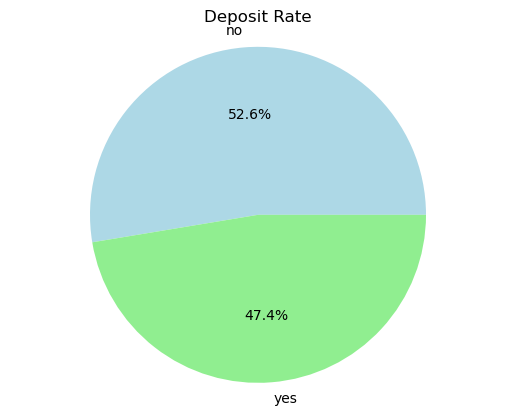

In [19]:
# value counts
deposit = df['deposit'].value_counts()

count = deposit.values
label = deposit.index

plt.pie(count, labels=label, 
        autopct='%1.1f%%',
        colors=['lightblue','lightgreen'])
plt.title('Deposit Rate')
plt.axis('equal')
plt.show()

Pie chart menunjukan bahwa 'deposit' cukup seimbang antara "yes" dan "no", dimana no 5% lebih banyak dari yes.

### Distribusi Numerik

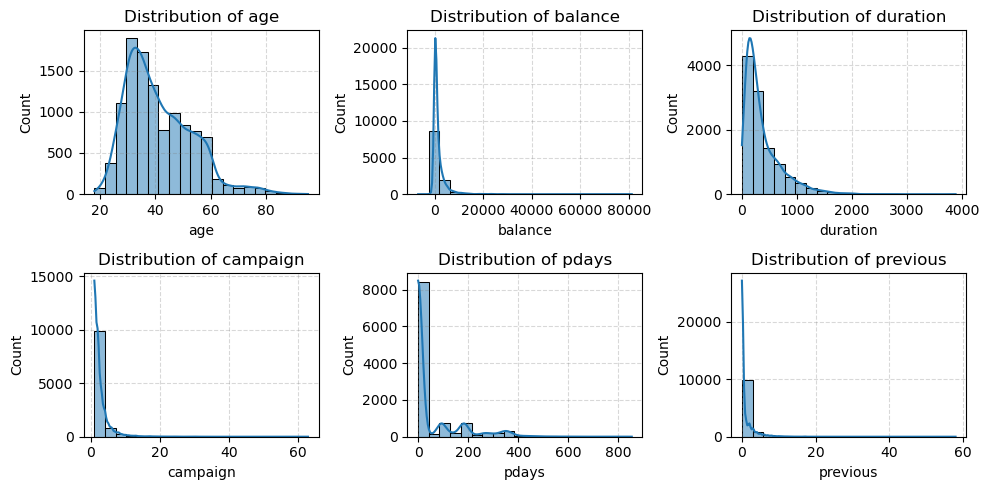

In [20]:
# set figure
plt.figure(figsize=(10,5))

# loop  buat histplot unutk setiap kolom
for i in range(0,len(num)):
    # set subplot 2x3
    plt.subplot(2, 3, i+1)
    
    # buat histplot
    sns.histplot(df[num[i]], kde=True, bins=20)

    # add gridline
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    # add title
    plt.title(f'Distribution of {num[i]}')

#show plot
plt.tight_layout()
plt.show()

Secara keseluruhan baik pada umur, saldo, durasi telepon, banyaknya kontak yang dilakukan selama kampanye, lamanya hari setelah kampanye terakhir, dan juga banyaknya kontak yang dilakukan sebelum kampanye dimulai menunjukkan bahwa kebanyakan nasabah memiliki nilai yang rendah dan ada beberapa yang nilainya lebih tinggi.
- Kebanyakan nasabah berumur antara 30-50 tahun dan ada beberapa yang jauh lebih tua. Hal in mengindikasikan bahwa nasabah kebanyakan berada di usia produktif.
- Mayoritas nasabah memiliki saldo kurang dari 5000 EUR dan ada beberapa yang jauh lebih banyak.
- Sebagian besar nasabah membutuhkan waktu dan kontak yang lebih sedikit pada kampanye kali ini maupun sebelumnya.
- Rata-rata kontak yang dilakukan sebelum kampanye ini juga 0. Sama dengan lamanya hari setelah kontak terakhir pada kampanye sebelumnya, Nilai minimal sampai dengan nilai tengah juga menunjukkan angka 0 yang mengindikasikan sebagian besar merupakan nasabah yang baru bergabung pada kampanye kali ini.

### Distribusi Kategorik

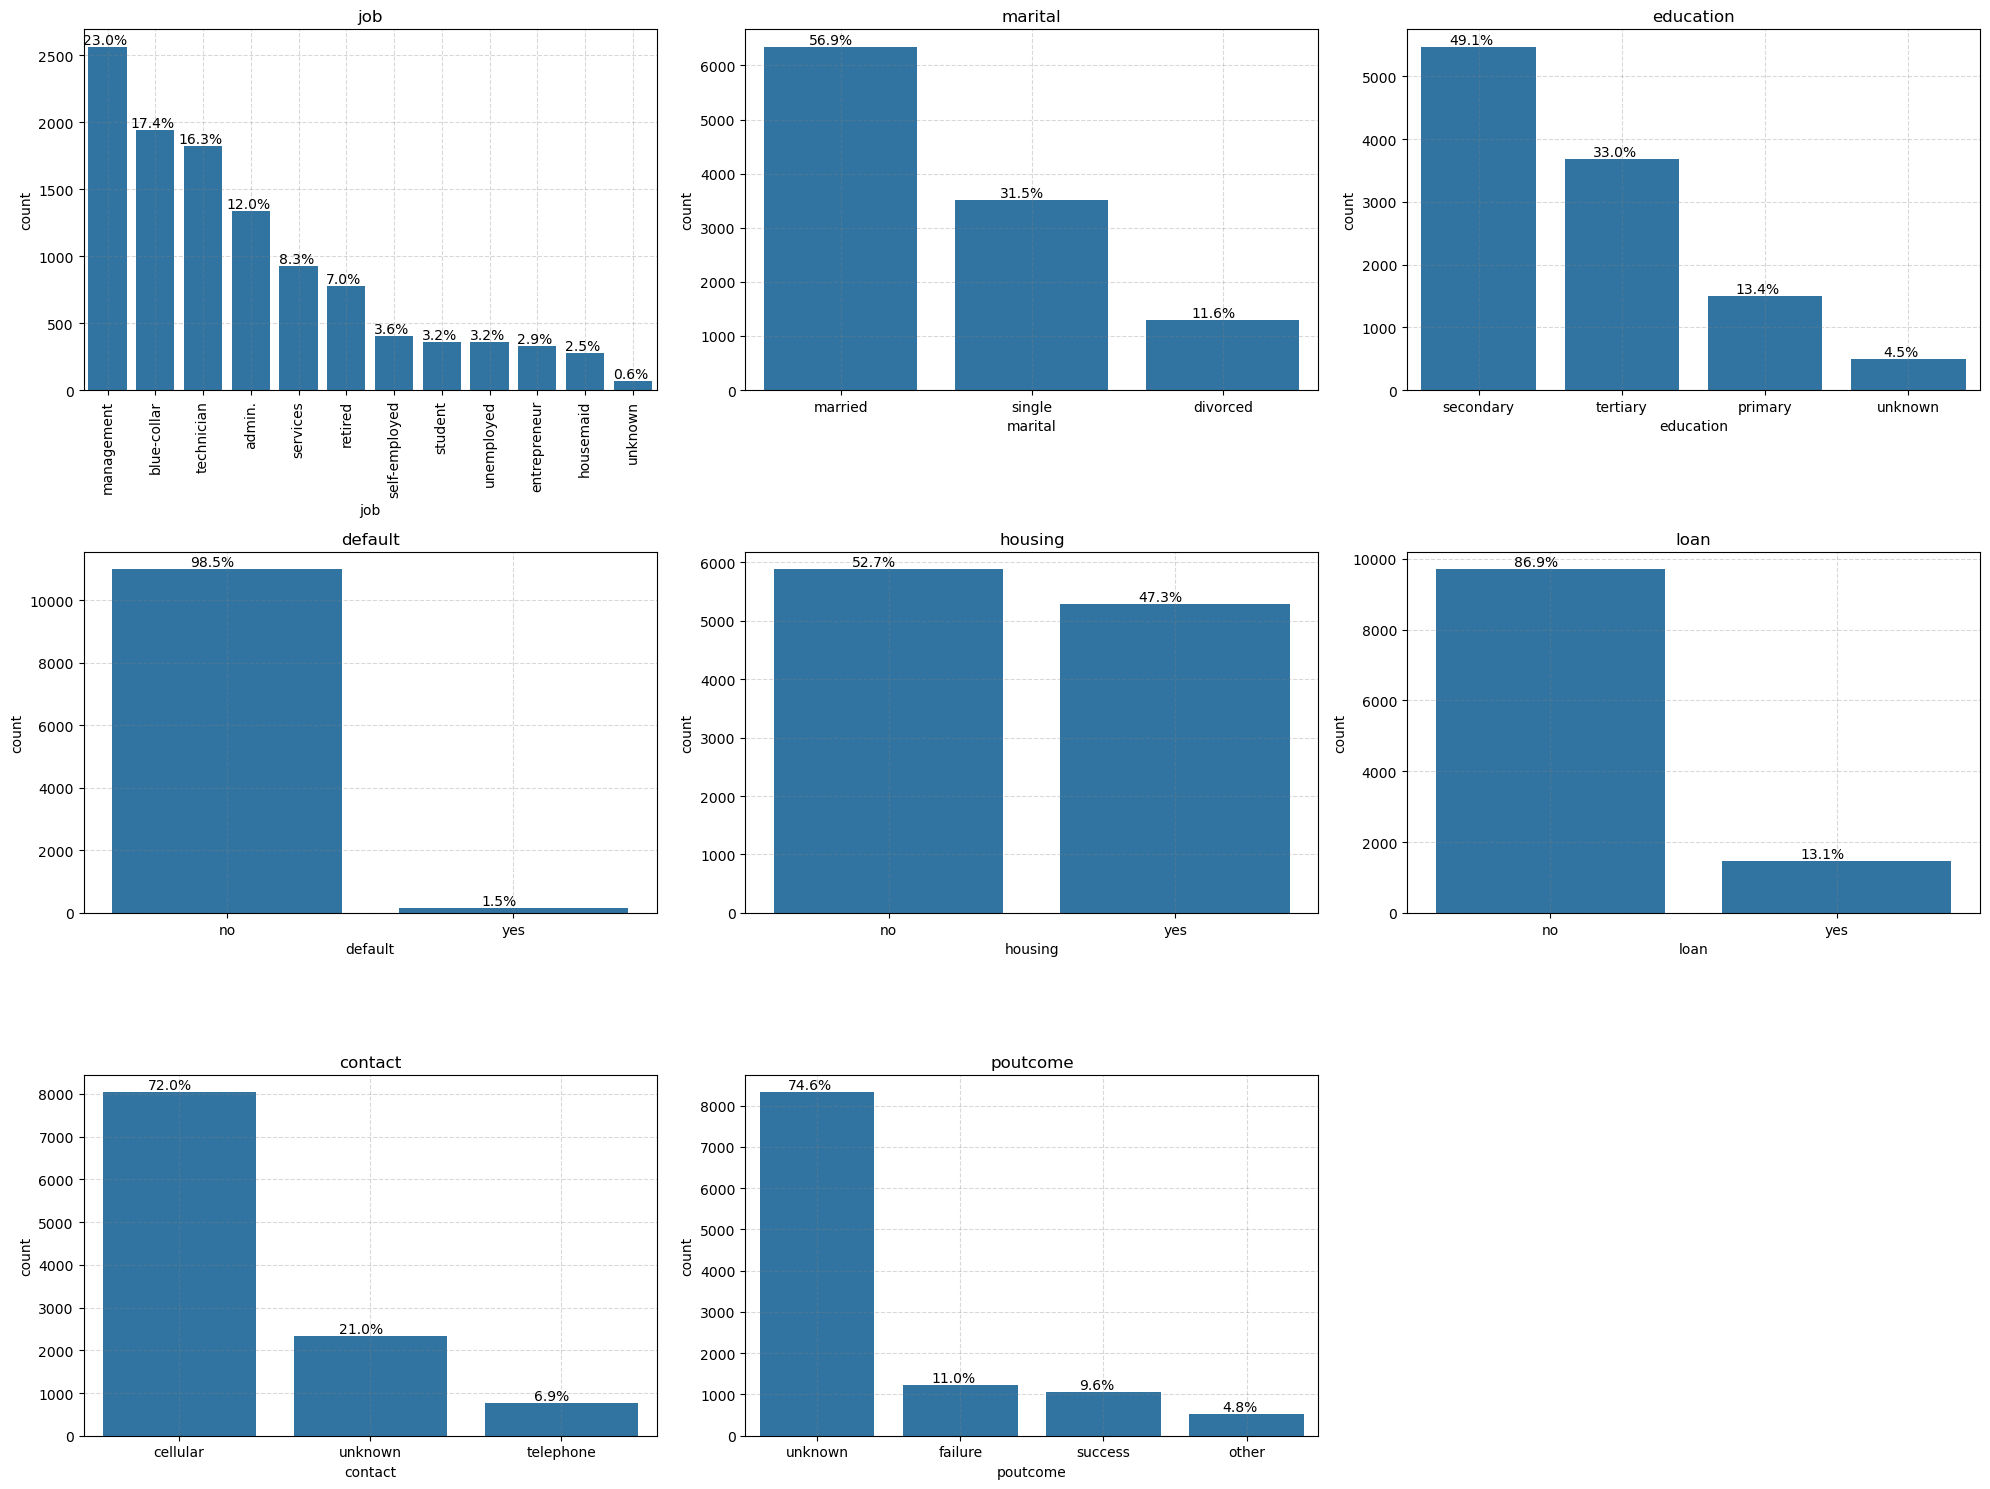

In [21]:
# copy variable kategorik
cat_1 = cat.copy()

# loop menghapus kolom yang tidak digunakan
for i in ['week', 'day', 'month','deposit']:
    # jika i ada dalam cat_1
    if i in cat_1:
        # remove i
        cat_1.remove(i)

#set figure
plt.figure(figsize=(20,15))

# loop histogram
for idx,i in enumerate(cat_1):
    # urut dari terbanyak
    urut = df[i].value_counts(ascending=False).index
    
    # subplot 3x3
    plt.subplot(3,3,idx+1)
    
    # plot histogram
    ax=sns.countplot(x=df[i],order=urut)

    # add gridline
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    # add title
    plt.title(i)
    # perlakuan kolom job
    if i=='job':
        # rotate x label 90 derajat
        plt.xticks(rotation=90)

    # menghitung panjang tiap bar
    total = float(len(df[i]))

    # loop untuk add persentase tiap kategori
    for p in ax.patches:
        # menghitung persentase per kategori
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        
        # menghitung lebar x dan y
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_height()

        # add persentase per kategori
        ax.annotate(percentage, (x, y), ha='center', va='bottom')

# show plot
plt.tight_layout()
plt.show()

- lebih dari 50% dari nasabah adalah orang-orang yang sudah menikah.
- Mayoritas nasabah bekerja di bidang manajemen (23%) dan sekitar 50% berpendidikan di tingkat *secondary education*.
- Kebanyakan nasabah tidak memiliki tanggungan rumah maupun pinjaman lainnya dan juga tidak pernah mengalami *credit default* atau kegagalan dalam membayar pinjaman. Namun perbandingan antara nasabah yang memiliki tanggungan rumah (53%) dan yang tidak (47%) relatif seimbang
- Hasil dari previous marketing terbanyak adalah "unknown" dengan persentase sebesar 74 %. Hal ini kemungkinan besar dikarenakan oleh mayoritas nasabah adalah nasabah yang baru mengikuti kampanye pada kali ini.
- Mayoritas nasabah menolak untuk berdeposit, tetapi perbedaannya dengan yang setuju untuk berdeposit relatif seimbang.

Lalu bagaimana dengan hal yang berhubungan dengan waktu?

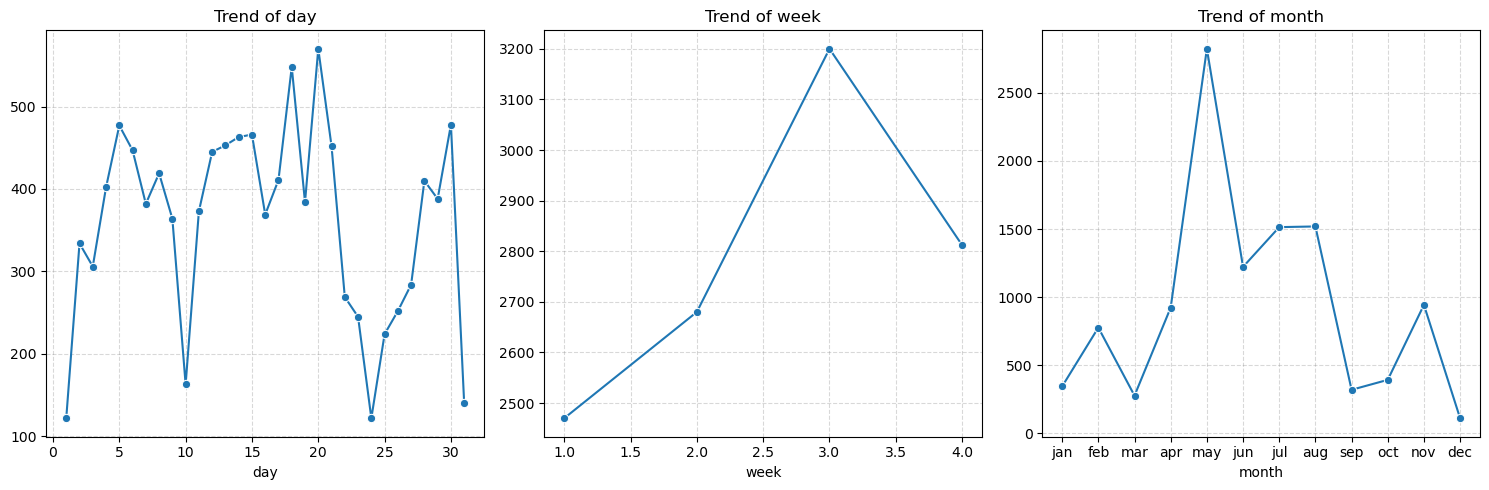

In [22]:
# categorik waktu
cat_2 = ['day', 'week', 'month']

# Urutan bulan
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Set figure
plt.figure(figsize=(15,5))

# Loop untuk setiap kategori
for idx, i in enumerate(cat_2):
    
    # Jika kolom adalah 'month', urutkan berdasarkan urutan bulan
    if i == 'month':
        df[i] = pd.Categorical(df[i], categories=month_order, ordered=True)
        data_agg = df.groupby(i).size()
    else:
        # Agregasi data untuk week dan day
        data_agg = df.groupby(i).size()
    
    # Subplot 1x3
    plt.subplot(1, 3, idx + 1)
    
    # Plot line plot
    sns.lineplot(x=data_agg.index, y=data_agg.values, marker="o")

    # Tambahkan gridline
    plt.grid(True, linestyle='--', color='grey', alpha=0.3)

    # Tambahkan title
    plt.title(f'Trend of {i}')

# Tampilkan plot
plt.tight_layout()
plt.show()

# mengembalikan dtype month ke object
df['month'] = df['month'].astype(object)

- Kontak terbanyak ditujukan oleh bank ke telepon seluler nasabah, pada tanggal 20 atau minggu ke-3, dan/atau bulan Mei. Tingginya kontak pada bulan mei mungkin berhubungan dengan adanya event finansial tertentu.
- Melihat dari tren, harian dan bulanan tidak menunjukkan adanya tren dalam jumlah kontak. Namun, ketika melihat tren mingguan, ditemukan bahwa awal dari mingggu pertama sampai dengan minggu ke-3 terjadi peningkatan jumlah kontak, sedangkan minggu ke-3 ke-minggu ke-4 terjadi penurunan tren. Hal ini mungkin terjadi karena pada minggu ke-3 biasanya orang-orang yang bekerja menerima gaji sehingga memperbesar kemungkinan nasabah untuk berdeposit.

## Bivariate Analysis

### Deposit by Job

Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'job' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'job' tidak berpengaruh terhadap 'deposit'.
- H1: 'job' berpengaruh terhadap 'deposit'.

In [23]:
# uji chi2
uji_chisquare(df,'job','deposit')

H0 berhasil ditolak: job berpengaruh terhadap deposit



(378.0752558664989, 2.741689587081072e-74, 11)

Uji Chi-Squared menunjukkan bahwa 'job' berpengaruh terhadap 'deposit'.

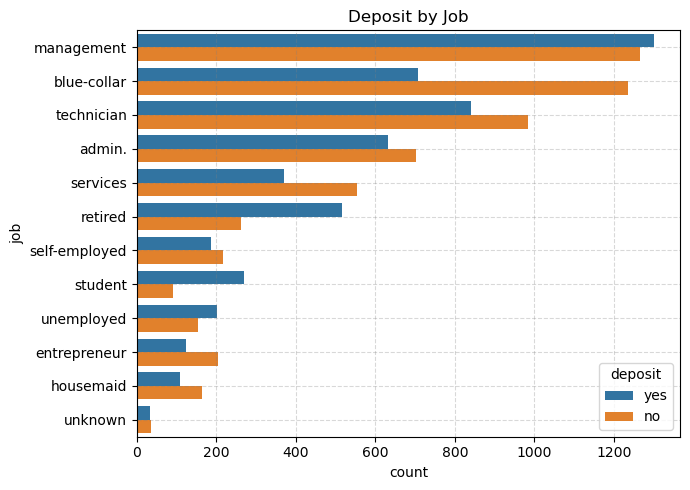

In [24]:
#set figure
plt.figure(figsize=(7,5))

# urut dari terbanyak
urut = df['job'].value_counts(ascending=False).index

# plot histogram
ax=sns.countplot(y=df['job'],order=urut,hue=df['deposit'])

# add gridline
plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
# add title
plt.title(f'Deposit by Job')

# show plot
plt.tight_layout()
plt.show()

Pada grafik terlihat bahwa walaupun top 3 pekerjaan terbanyak dalam data adalah manajemen, blue-collar, dan technician, tidak semuanya menunjukkan jumlah nasabah berdeposit yang lebih tinggi dari yang tidak. Justru pekerjaan pekerjaan yang menunjukkan jumlah nasabah berdeposit lebih besar dari yang tidak adalah pekerjaan pasif seperti pensiunan, pelajar, unemployed ditambah dengan manajemen.

In [25]:
# create crosstable
cross_table = pd.crosstab(df['job'],df['deposit'])

# calculate rate
cross_table['yes_rate'] = (cross_table['yes'] / (cross_table['yes'] + cross_table['no']))*100

# show crosstable
cross_table.sort_values(by='yes_rate',ascending=False)

deposit,no,yes,yes_rate
job,,,
student,91,269,74.722222
retired,262,516,66.323907
unemployed,155,202,56.582633
management,1265,1301,50.701481
unknown,36,34,48.571429
admin.,703,631,47.301349
self-employed,218,187,46.172840
technician,983,840,46.077894
services,554,369,39.978332


Nasabah dengan pekerjaan sebagai pelajar, pensiunan, belum bekerja, dan manajemen secara berturut turut dari yang terbesar menghasilkan persentase keberhasilan lebih dari 50%, sedangkan jenis pekerjaan lainnya dibawah 50%. Melihat bahwa data menunjukkan nasabah yang tidak aktif bekerja memiliki persentase keberhasilan yang cukup tinggi (bahkan pelajar mencapai 74%) menandakan bahwa orang-orang ini lebih bergantung kepada pasive income, sedangkan orang yang bekerja sebagai manajemen biasanya memiliki pengetahuan yang lebih mengenai finansial sehingga cenderung akan berdeposit.

### Deposit by Marital
Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'marital' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'marital' tidak berpengaruh terhadap 'deposit'.
- H1: 'marital' berpengaruh terhadap 'deposit'.

In [26]:
# uji chi2
uji_chisquare(df,'marital','deposit')

H0 berhasil ditolak: marital berpengaruh terhadap deposit



(109.58335610012479, 1.600576988089358e-24, 2)

Uji Chi-Squared menunjukkan bahwa 'marital' berpengaruh terhadap 'deposit'.

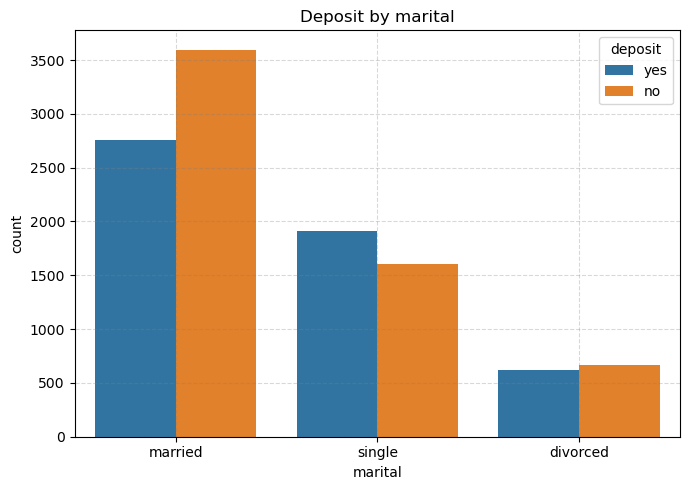

In [27]:
#set figure
plt.figure(figsize=(7,5))

# urut dari terbanyak
urut = df['marital'].value_counts(ascending=False).index

# plot histogram
ax=sns.countplot(x=df['marital'],order=urut,hue=df['deposit'])

# add gridline
plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
# add title
plt.title(f'Deposit by marital')

# show plot
plt.tight_layout()
plt.show()

Berdasarkan grafik diatas, didapatkan bahwa status 'single' cenderung berdeposit dibanding lainnya. Hal ini mungkin diakibatkan karena orang yang masih single biasanya belum atau hanya memiliki tanggungan untuk dirinya sendiri, sedangkan orang yang sudah pernah menikah memiliki tanggungan lain, seperti istri atau anak yang menyebabkan tidak adanya dana untuk berdeposit.

### Deposit by Education
Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'education' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'education' tidak berpengaruh terhadap 'deposit'.
- H1: 'education' berpengaruh terhadap 'deposit'.

In [28]:
# uji chi2
uji_chisquare(df,'education','deposit')

H0 berhasil ditolak: education berpengaruh terhadap deposit



(122.77008967211442, 1.9534186354212715e-26, 3)

Uji Chi-Squared menunjukkan bahwa 'education' berpengaruh terhadap 'deposit'.

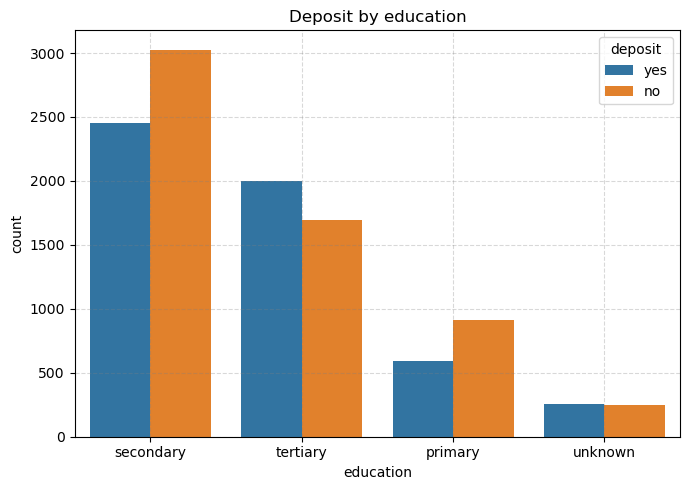

In [29]:
#set figure
plt.figure(figsize=(7,5))

# urut dari terbanyak
urut = df['education'].value_counts(ascending=False).index

# plot histogram
ax=sns.countplot(x=df['education'],order=urut,hue=df['deposit'])

# add gridline
plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
# add title
plt.title(f'Deposit by education')
# perlakuan kolom education

# show plot
plt.tight_layout()
plt.show()

Dari grafik di atas, didapatkan bahwa nasabah yang memiliki edukasi pada tingkat 'tertiary' memiliki persentase yang lebih besar untuk berdeposit. Hal ini mungkin dikarenakan nasabah-nasabah tersebut sudah lebih paham dan sadar akan manfaat deposito karena terpapar ketika menjalani pendidikan pada tingkat tertiary.

In [30]:
# create crosstable
cross_table = pd.crosstab(df['education'],df['deposit'])

# calculate rate
cross_table['yes_rate'] = (cross_table['yes'] / (cross_table['yes'] + cross_table['no']))*100

# show crosstable
cross_table.sort_values(by='yes_rate',ascending=False)

deposit,no,yes,yes_rate
education,,,
tertiary,1693,1996,54.106804
unknown,245,252,50.704225
secondary,3026,2450,44.740687
primary,909,591,39.400000


Setelah melihat lebih detail pada crosstable, ternyata pendidikan tingkat 'unknown' juga memiliki persentase nasabah berdeposit yang lebih besar, tetapi tidak signifikan berbeda.

### Deposit by Default, Housing & Loan
Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'default'/'housing'/'loan' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'default'/'housing'/'loan' tidak berpengaruh terhadap 'deposit'.
- H1: 'default'/'housing'/'loan' berpengaruh terhadap 'deposit'.

In [31]:
# loop uji chi2
for i in ['default','housing','loan']:
    #tampilkan anma kolom
    print(i)
    #uji chi2
    uji_chisquare(df,i,'deposit')

default
H0 berhasil ditolak: default berpengaruh terhadap deposit

housing
H0 berhasil ditolak: housing berpengaruh terhadap deposit

loan
H0 berhasil ditolak: loan berpengaruh terhadap deposit



Dari ketiga uji Chi-Squared, hasil menunjukkan bahwa 'default'/'housing'/'loan' berpengaruh terhadap 'deposit'.

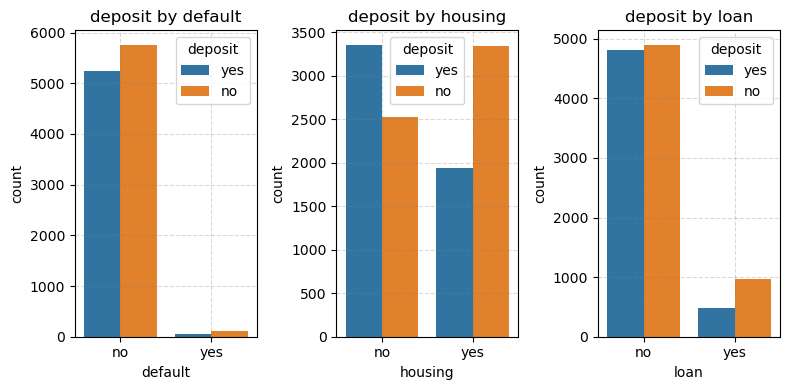

In [32]:
#set figure
plt.figure(figsize=(8,4))

# loop histogram
for idx,i in enumerate(['default', 'housing', 'loan']):
    # urut dari terbanyak
    urut = df[i].value_counts(ascending=False).index
    
    # subplot 1x3
    plt.subplot(1,3,idx+1)
    
    # plot histogram
    ax=sns.countplot(x=df[i],order=urut,hue=df['deposit'])

    # add gridline
    plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
    # add title
    plt.title(f'deposit by {i}')
    # perlakuan kolom job
    if i=='job':
        # rotate x label 90 derajat
        plt.xticks(rotation=90)

# show plot
plt.tight_layout()
plt.show()

- Pada grafik default dan loan menunjukkan hasil yang cukup mirip, dimana walaupun nasabah yang memilih untuk tidak berdeposit lebih tinggu,nasabah yang tidak pernah mengalami gagal bayar dan yang tidak memiliki pinjaman cenderung berdeposit. Hal ini sangat wajar karena biasanya mereka dapat dianggap lebih stabil secara finansial.
- Pada grafik  housing, terlihat jelas bahwa nasabah yang tidak memiliki tanggungan rumah lebih cenderung akan berdeposit.

### Deposit by Contact
Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'contact' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'contact' tidak berpengaruh terhadap 'deposit'.
- H1: 'contact' berpengaruh terhadap 'deposit'.

In [33]:
# uji chi2
uji_chisquare(df,'contact','deposit')

H0 berhasil ditolak: contact berpengaruh terhadap deposit



(736.6866796046972, 1.0728032438445805e-160, 2)

Uji Chi-Squared menunjukkan bahwa 'contact' berpengaruh terhadap 'deposit'.

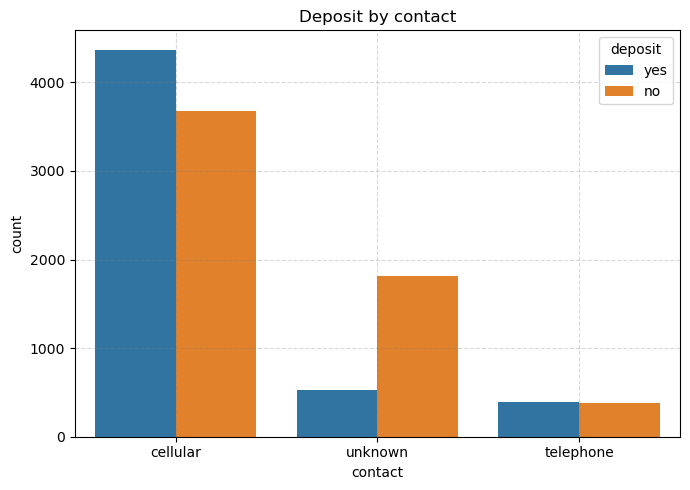

In [34]:
#set figure
plt.figure(figsize=(7,5))

# urut dari terbanyak
urut = df['contact'].value_counts(ascending=False).index

# plot histogram
ax=sns.countplot(x=df['contact'],order=urut,hue=df['deposit'])

# add gridline
plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
# add title
plt.title(f'Deposit by contact')
# perlakuan kolom contact

# show plot
plt.tight_layout()
plt.show()

Dari grafik di atas, didapatkan bahwa nasabah yang dihubungi melalui telepon selularnya lebih cenderung berdeposit. Begitupula dengan yang melalui telepon, namun tidak signifikan berbeda dan jumlahnya lebih sedikit. Hal ini mungkin berkaitan dengan umur, dimana biasanya orang-orang yang lebih muda cenderung lebih mengikuti perkembangan teknologi sehingga sangat mungkin untuk memiliki telepon selular.

### Deposit by Poutcome
Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'poutcome' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'poutcome' tidak berpengaruh terhadap 'deposit'.
- H1: 'poutcome' berpengaruh terhadap 'deposit'.

In [35]:
# uji chi2
uji_chisquare(df,'poutcome','deposit')

H0 berhasil ditolak: poutcome berpengaruh terhadap deposit



(1004.635780185333, 1.7761850102620281e-217, 3)

Uji Chi-Squared menunjukkan bahwa 'poutcome' berpengaruh terhadap 'deposit'.

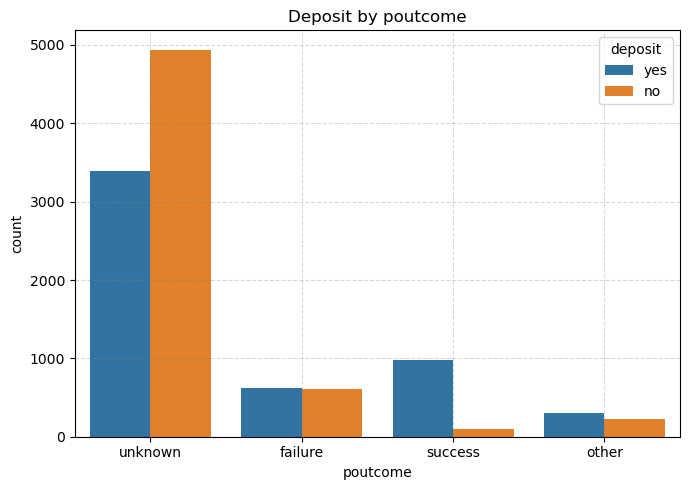

In [36]:
#set figure
plt.figure(figsize=(7,5))

# urut dari terbanyak
urut = df['poutcome'].value_counts(ascending=False).index

# plot histogram
ax=sns.countplot(x=df['poutcome'],order=urut,hue=df['deposit'])

# add gridline
plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
# add title
plt.title(f'Deposit by poutcome')
# perlakuan kolom poutcome

# show plot
plt.tight_layout()
plt.show()

Dari grafik di atas, didapatkan bahwa nasabah yang memilih berdeposit pada kampanye sebelumnya cenderung akan melakukannya lagi. Nasabah yang tidak berdeposit pada kampanye sebelumnya dan yang memilih lainnya juga memilih untuk berdeposit pada kampanye kali ini, tetapi perbedaanya tidak signifikan dengan nasabah yang menolak berdeposit.

### Deposit by Week
Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'week' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'week' tidak berpengaruh terhadap 'deposit'.
- H1: 'week' berpengaruh terhadap 'deposit'.

In [37]:
# uji chi2
uji_chisquare(df,'week','deposit')

H0 berhasil ditolak: week berpengaruh terhadap deposit



(58.62260465076986, 1.157345950853024e-12, 3)

Uji Chi-Squared menunjukkan bahwa 'week' berpengaruh terhadap 'deposit'.

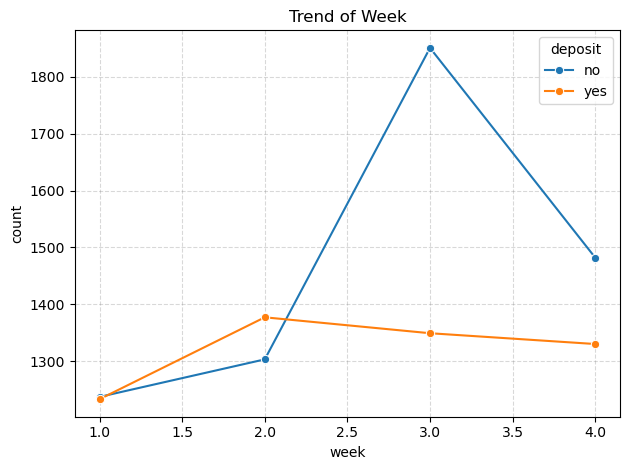

In [38]:
# Agregasi data untuk setiap kategori
data_agg = df.groupby(['week', 'deposit']).size().reset_index(name='count')

# Plot line plot
sns.lineplot(data=data_agg, x='week', y='count', marker="o", hue='deposit')

# Tambahkan gridline
plt.grid(True, linestyle='--', color='grey', alpha=0.3)

# Tambahkan title
plt.title('Trend of Week')

# Tampilkan plot
plt.tight_layout()
plt.show()

Hasil grafik menunjukkan bahwa, walaupun terjadinya kontak terbanyak ada pada minggu ke-3, tetapi lebih banyak terjadi nasabah yang berdeposit justru pada minggu pertama.

### Numerik vs Target
Perlu dilakukan uji Chi-Squared untuk mengetahui apakah 'age', 'balance', 'duration', 'campaign', 'pdays' atau 'previous' berpengaruh terhadap 'deposit' dengan hipotesis sebagai berikut:
- H0: 'age'/'balance'/'duration'/'campaign'/'pdays'/'previous' tidak berpengaruh terhadap 'deposit'.
- H1: 'age'/'balance'/'duration'/'campaign'/'pdays'/'previous' berpengaruh terhadap 'deposit'.

In [39]:
# loop uji kendall
for i in num:
    #tampilkan anma kolom
    print(i)
    #uji chi2
    uji_kendall(df,i,'deposit')

age
koefisien corr = -0.010057572034778101
pvalue = 0.19904783872803178

H0 gagal ditolak: age TIDAK berkorelasi dengan deposit

balance
koefisien corr = 0.12898680374909846
pvalue = 3.1262577111669284e-62

H0 berhasil ditolak: balance berkorelasi dengan deposit

duration
koefisien corr = 0.43127457974341843
pvalue = 0.0

H0 berhasil ditolak: duration berkorelasi dengan deposit

campaign
koefisien corr = -0.11547653758829719
pvalue = 7.73367269931392e-41

H0 berhasil ditolak: campaign berkorelasi dengan deposit

pdays
koefisien corr = 0.19964586940571818
pvalue = 6.234395851131339e-112

H0 berhasil ditolak: pdays berkorelasi dengan deposit

previous
koefisien corr = 0.21852528778629784
pvalue = 2.598716071911125e-130

H0 berhasil ditolak: previous berkorelasi dengan deposit



Dari hasil uji kendall, dapat dikatakan bahwa seluruh fitur kecuali 'age' berkorelasi dengan 'deposit'.

### Korelasi Antar Fitur Numerik

<Axes: >

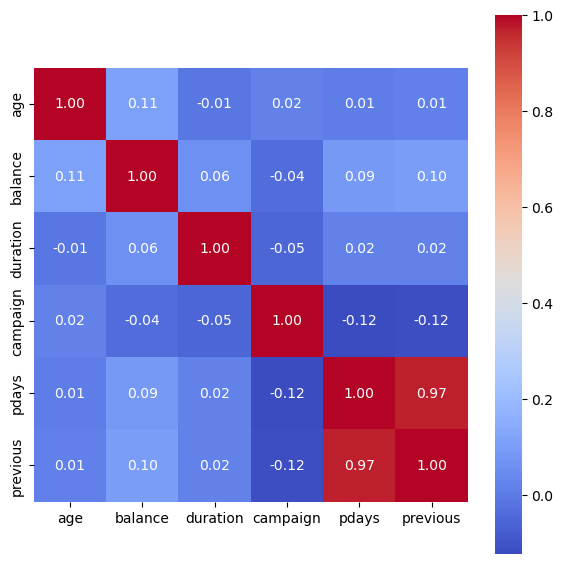

In [40]:

plt.figure(figsize=(7,7))
sns.heatmap(df[num].corr(method='spearman'),annot=True,fmt='.2f',square=True,cmap='coolwarm')

Fitur 'pdays' memiliki korelasi positif yang sangat kuat dengan fitur 'previous', dimana semakin banyak kontak yang dilakukan sebelum kampanye, maka semakin banyak jumlah hari berlalu sejak kontak terakhir.

# Feature Engineering

Untuk memastikan semua proses bermula dari awal, maka data akan direset dari df_org.

In [41]:
# load original
df = df_org.copy()

In [42]:
# divide numeric & categoric
num = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
cat = df.drop(columns=num).columns.tolist()

## Cardinality Handling

'day' merupakan kolom kategorik yang memiliki terlalu banyak unique value. Untuk mengatasinya, akan dibuat kolom 'week' yang mengelompokan data per tanggal (hari) menjadi per minggu.

In [43]:
# inisiasi list untuk menampung week
week = []

# loop deteksi minggu berdasarkan tanggal
for i in df['day']:
    # kondisi tanggal 1-7
    if i <= 7:
        # add minggu ke-1 ke list
        week.append(1)
    # kondisi tanggal 8-14
    elif i <= 14:
        # add minggu ke-2 ke list
        week.append(2)
    # kondisi tanggal 15-21
    elif i <= 21:
        # add minggu ke-3 ke list
        week.append(3)
    # kondisi tanggal 22-31
    elif 21 < i <= 31:
        # add minggu ke-4 ke list
        week.append(4)
    # kondisi lainnya
    else:
        # add NA ke list0
        week.append(pd.NA)

# add 'week' to dataframe
df['week'] = week

df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,week
8710,33,services,single,secondary,no,-27,yes,no,unknown,26,may,165,1,-1,0,unknown,no,4
2648,34,management,single,tertiary,no,268,no,no,cellular,7,sep,587,1,-1,0,unknown,yes,1
9056,47,housemaid,married,secondary,yes,-1531,yes,no,cellular,31,jul,156,8,-1,0,unknown,no,4
3976,49,technician,married,tertiary,no,1071,no,no,cellular,16,sep,225,1,91,1,success,yes,3
233,29,services,single,secondary,no,32,yes,no,unknown,4,jun,563,1,-1,0,unknown,yes,1


In [44]:
# check missing value
df['week'].isna().sum()

0

Kolom 'week' sudah ditambahkan berdasarkan 'day' dan tidak terdapat value yang melebihi tanggal maksimal (31).

In [45]:
# save
df_card = df.copy()

In [46]:
# load
df = df_card.copy()

## Data Spliting

Untuk menghindari data leakage, spliting data perlu dilakukan sebelum melakukan handling outlier, missung value, dll. Data akan di-split dengan perbandingan 80:20.

In [47]:
# fitur & target
X = df.drop(columns='deposit')
y = df[['deposit']]

#split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# train-test set
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [48]:
# divide numeric & categoric
X_num = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
X_cat = cat.copy()
#add week
X_cat.append('week')
# remove target
X_cat.remove('deposit')

In [49]:
# save train & test
X_train_org = X_train.copy()
X_test_org  = X_test.copy()
y_test_org  = y_test.copy()
y_train_org = y_train.copy()

In [50]:
# Load
X_train = X_train_org.copy()
X_test  = X_test_org.copy()
y_test  = y_test_org.copy()
y_train = y_train_org.copy()

## Handling Missing Values

Seperti yang sudah dijelaskan di atas bahwa terdapat beberapa value yang kemungkinan value tersebut adalah non-standart missing value yang perlu ditelaah lebih dalam. Untuk mengetahuinya, perlu dicari kolom mana saja yang mengandung terduga missing value tersebut.

In [51]:
# loop filter kolom yang mengandung "."
for i in X_train.columns.tolist():
    # jika kolom mengandung value "."
    if X_train[i].astype(str).str.contains(r'-|unknown').any():
        # tampilkan kolom yang mengandung value "."
        print(i)
        print(f'{i} : {X_train[i].unique().tolist()}\n')

job
job : ['admin.', 'technician', 'blue-collar', 'services', 'housemaid', 'management', 'self-employed', 'retired', 'unknown', 'student', 'unemployed', 'entrepreneur']

education
education : ['secondary', 'tertiary', 'unknown', 'primary']

balance
balance : [526, 2552, 139, 3288, 217, 368, 3165, 71, 609, 451, 105, 412, 5214, 30, 2674, 5539, 137, 0, 16, 1466, 464, 1467, 86, 1808, 40, -253, 5299, 990, 4787, 997, 444, 244, 2642, 548, 803, 1414, 830, 213, 418, 242, 2488, 163, 805, 342, 1942, -700, 2892, 22867, 5372, 1006, 405, 1273, 4910, 3399, 151, -1, 387, 601, 154, 1146, 947, 539, 396, 84, 2276, 984, 7, 335, 7968, 4761, 20, 263, 542, 183, 333, 50, 882, 760, 1207, 1458, 2313, 206, 13711, 3770, -9, 26, 372, 2556, 9051, 2948, 2551, 289, 23, 3025, 568, 54, 1188, 322, 1495, 426, 1694, 2544, 1313, 900, -701, 15, 25, 874, 3387, 233, 580, 1764, 1012, -6, 5845, 1859, 79, 131, 1396, 292, 3285, 3287, 827, 432, 1625, 395, 438, 196, -170, 697, 910, 313, 60, 297, 70, 390, -197, 3676, -271, 4564, 893

Terdeteksi 'job', 'education', 'balance', 'contact', 'pdays', dan 'poutcome' mengandung "-" dan/atau "unknown". Namun seperti yang sudah kita ketahui juga, sangat wajar jika 'balance' mengandung negatif karena berarti nasabah tersebut memiliki kewajiban yang belum terpenuhi (autodebit, charge bulanan, dll) karena saldo tidak mencukupi.

Unknown: 'job', 'education', 'contact', 'poutcome'<br>
Minus: 'pdays'

### MissVal Pdays

**Pdays Misssing Value: MNAR**<br>
Berdasarkan deskripsi data, "-1" pada 'pdays' adalah nasabah yang belum pernah dikontak pada periode pemasaran sebelumnya, dapat dikatakan nilainya sama dengan "0". Maka, `value "-1" pada 'pdays' dapat diganti dengan 0 untuk mempermudah interpretasi`.

In [52]:
# jumlah -1
print('jumlah -1 (before):',len(X_train[X_train['pdays']==-1]))

# replace -1 dengan 0
X_train['pdays'].replace(-1,0,inplace=True)
X_test['pdays'].replace(-1,0,inplace=True)

# jumlah 0
print('jumlah 0 (after)',len(X_train[X_train['pdays']==0]))

jumlah -1 (before): 6642
jumlah 0 (after) 6642


Jumlah "-1" (sebelum pergantian value) dan "0" (setelah pergantian value) sama, artinya seluruh "-1" pada 'pdays' berhasil diubah ke "0".

### MissVal Job

In [53]:
# filter job unknown
job_fil = X_train[X_train['job']=='unknown']
job_fil.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
10805,51,unknown,married,unknown,no,2642,no,no,cellular,29,jul,52,6,0,0,unknown,4
1548,50,unknown,married,primary,no,341,yes,yes,cellular,20,apr,670,4,340,2,success,3
3913,48,unknown,single,unknown,no,1819,no,no,cellular,2,sep,1440,1,458,1,failure,1
2440,65,unknown,married,unknown,no,4717,no,no,telephone,6,aug,256,1,0,0,unknown,1
5400,55,unknown,married,secondary,no,1157,no,no,cellular,12,jul,289,1,412,2,failure,2


- Ditemukan bahwa 5 baris pertama dan 5 baris terakhir ketika 'job' adalah "unknown" maka 'default adalah "no". Hal ini mungkin berkaitan dengan missing value yang terjadi, `perlu dicek apakah terdapat ketika 'job' adalah "unknown" dan 'default adalah "yes" atau sebaliknya`. Jika ada, maka "unknown pada 'job' tidak bisa dikatakan disebabkan oleh 'default'.
- Tidak ditemukan adanya pola serupa atau kekonsistenan antara ketika 'job' adalah "unknown" dengan value fitur lain.

In [54]:
# filter job unknown, default yes
job_fil[job_fil['default']=='yes']

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
7074,42,unknown,single,unknown,yes,61,no,no,unknown,20,jun,115,1,0,0,unknown,3


**Job Misssing Value: MNAR**<br>
Terdapat value ketika 'job' adalah "unknown" dan 'default adalah "yes" atau sebaliknya`. Maka "unknown pada 'job' tidak bisa dikatakan disebabkan oleh 'default'. Kemungkinan value "unknown" disebabkan oleh orang orang yang tidak ingin diketahui pekerjaannya karena satu dan lain hal.

Imputasi berdasarkan distribusi data: Modus.

In [55]:
# modus
modus = X_train['job'].mode()[0]

# replace unknown dengan mode
X_train['job'].replace("unknown",modus,inplace=True)
X_test['job'].replace("unknown",modus,inplace=True)

# check data
X_train[X_train['job']=='unknown']

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week


### MissVal Education

In [56]:
# filter education unknown
edu_fil = X_train[X_train['education']=='unknown']
edu_fil

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
4006,37,blue-collar,single,unknown,no,217,no,no,cellular,23,sep,272,2,0,0,unknown,4
10805,51,management,married,unknown,no,2642,no,no,cellular,29,jul,52,6,0,0,unknown,4
3072,41,technician,single,unknown,no,5372,yes,no,cellular,13,jan,248,3,0,0,unknown,2
4721,49,technician,divorced,unknown,no,387,no,no,cellular,28,jan,325,1,0,0,unknown,4
7635,45,management,married,unknown,no,9051,yes,no,unknown,19,may,124,63,0,0,unknown,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,38,admin.,single,unknown,no,446,yes,no,unknown,13,may,386,1,0,0,unknown,2
2736,54,management,married,unknown,no,895,no,no,cellular,7,oct,335,1,0,0,unknown,1
6504,39,technician,single,unknown,no,0,yes,no,unknown,7,may,130,1,0,0,unknown,1
7876,42,admin.,single,unknown,no,22,no,no,unknown,19,jun,246,3,0,0,unknown,3


- Ditemukan bahwa 5 baris pertama dan 5 baris terakhir ketika 'education' adalah "unknown" maka 'default' dan 'loan' adalah "no". Hal ini mungkin berkaitan dengan missing value yang terjadi, `perlu dicek apakah terdapat ketika 'education' adalah "unknown" dan 'default'/'loan' adalah "yes" atau sebaliknya`. Jika ada, maka "unknown pada 'education' tidak bisa dikatakan disebabkan oleh 'default'/'loan'.
- Kemunkinan "unknown" adalah orang-orang yang tidak mengenyam pendidikan yang biasanya memiliki pekerjaan yang gajinya dibawah rata-rata, tetapi `perlu dilakukan pengacekan dengan kolom 'job'` untuk memvalidasinya.
- Tidak ditemukan adanya pola serupa atau kekonsistenan antara ketika 'education' adalah "unknown" dengan value fitur lain.

In [57]:
# filter edu unknown, default yes
edu_fil[edu_fil['default']=='yes'].sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
623,49,entrepreneur,divorced,unknown,yes,-701,yes,no,cellular,30,jul,988,2,0,0,unknown,4
7593,44,technician,married,unknown,yes,-375,yes,yes,telephone,6,may,149,4,0,0,unknown,1
858,47,blue-collar,married,unknown,yes,162,no,no,cellular,25,aug,366,3,0,0,unknown,4


In [58]:
# filter edu unknown, loan yes
edu_fil[edu_fil['loan']=='yes'].sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
9731,51,admin.,married,unknown,no,-1137,yes,yes,telephone,11,may,567,3,325,1,failure,2
9264,56,blue-collar,married,unknown,no,982,yes,yes,cellular,7,may,135,2,0,0,unknown,1
6136,34,blue-collar,married,unknown,no,391,yes,yes,unknown,23,may,34,2,0,0,unknown,4


In [59]:
# group by job & education
job_group = X_train.groupby(['education','job']).size()
job_group

education  job          
primary    admin.             32
           blue-collar       550
           entrepreneur       34
           housemaid         121
           management         63
           retired           217
           self-employed      21
           services           63
           student            19
           technician         34
           unemployed         47
secondary  admin.            868
           blue-collar       878
           entrepreneur      110
           housemaid          64
           management        200
           retired           245
           self-employed     106
           services          585
           student           156
           technician        978
           unemployed        167
tertiary   admin.            137
           blue-collar        44
           entrepreneur      100
           housemaid          33
           management       1769
           retired           112
           self-employed     174
           service

**Education Misssing Value: MNAR**<br>
Terdapat value ketika 'education' adalah "unknown" dan 'default'/'loan' adalah "yes" atau sebaliknya` dan unknown juga bukanlah orang-orang yang tidak mengenyam pendidikan karena ada banyak orang yang bekerja di pekerjaan yuang membutuhkan pengetahuan seperti teknisi, student, dll. Maka "unknown" pada 'education' tidak bisa dikatakan disebabkan oleh 'default'/'loan'. Kemungkinan value "unknown" disebabkan oleh orang orang yang tidak ingin diketahui pekerjaannya karena satu dan lain hal.

Membiarkan "unknown" menjadi kategori baru.

### MissVal Contact

In [60]:
# filter contact unknown
contact_fil = X_train[X_train['contact']=='unknown']
contact_fil

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
4605,36,technician,married,secondary,no,368,yes,yes,unknown,6,may,1597,2,0,0,unknown,1
8253,38,services,married,secondary,no,3165,yes,no,unknown,12,may,152,2,0,0,unknown,2
10498,34,management,married,tertiary,no,105,yes,no,unknown,6,may,314,3,0,0,unknown,1
8625,27,self-employed,single,tertiary,no,5214,yes,no,unknown,28,may,94,1,0,0,unknown,4
7323,41,technician,single,secondary,no,30,no,no,unknown,23,may,1003,1,0,0,unknown,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,40,blue-collar,married,primary,no,7831,yes,no,unknown,14,may,78,1,0,0,unknown,2
9028,36,admin.,single,secondary,no,787,no,no,unknown,17,jun,92,1,0,0,unknown,3
10493,52,management,married,tertiary,no,575,no,no,unknown,3,jun,315,1,0,0,unknown,1
10709,40,services,married,secondary,no,2346,no,no,unknown,16,jun,182,3,0,0,unknown,3


Ditemukan bahwa 5 baris pertama dan 5 baris terakhir ketika 'contact' adalah "unknown" maka 'default'/'loan'/'poutcome'/'pdays' adalah "no"/"0"/"unknown". Hal ini mungkin berkaitan dengan missing value yang terjadi, `perlu dicek apakah terdapat ketika 'contact' adalah "unknown" dan 'default'/'loan'/'poutcome'/'pdays' adalah "no"/"0"/"unknown" atau sebaliknya`. Jika ada, maka "unknown" pada 'contact' tidak bisa dikatakan disebabkan oleh 'default'/'loan'/'poutcome'/'pdays'.

In [61]:
# filter contact unknown, pdays 0
print('pdays 0:',X_train[(X_train['contact'] == 'unknown') & (X_train['pdays'] == 0)].shape[0])

# filter contact unknown, poutcome unknown
print('poutcome 0:',X_train[(X_train['contact'] == 'unknown') & (X_train['poutcome'] == 'unknown')].shape[0])

# filter contact unknown, loan no
print('loan no:',X_train[(X_train['contact'] == 'unknown') & (X_train['loan'] == 'no')].shape[0])

# filter contact unknown, default no
print('default no:',X_train[(X_train['contact'] == 'unknown') & (X_train['default'] == 'no')].shape[0])

pdays 0: 1862
poutcome 0: 1862
loan no: 1614
default no: 1830


**Contact Misssing Value: MCAR**<br>
Nilai "unknown" pada kolom 'contact' bisa berarti informasi mengenai cara kontak dengan nasabah tidak tersedia karena tidak tercatat saat kampanye dilakukan. Hal ini terjadi secara acak tanpa alasan spesifik.

Imputasi berdasarkan distribusi data: Modus.

In [62]:
# modus
modus = X_train['contact'].mode()[0]

# replace unknown dengan mode
X_train['contact'].replace("unknown",modus,inplace=True)
X_test['contact'].replace("unknown",modus,inplace=True)

# check data
X_train[X_train['contact']=='unknown']

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week


### MissVal Poutcome

In [63]:
# filter poutcome unknown
poutcome_fil = X_train[X_train['poutcome']=='unknown']
poutcome_fil

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
8644,46,admin.,married,secondary,no,526,no,yes,cellular,31,jul,251,3,0,0,unknown,4
1080,43,technician,married,secondary,no,3288,yes,no,cellular,21,nov,775,3,0,0,unknown,3
4006,37,blue-collar,single,unknown,no,217,no,no,cellular,23,sep,272,2,0,0,unknown,4
4605,36,technician,married,secondary,no,368,yes,yes,cellular,6,may,1597,2,0,0,unknown,1
8253,38,services,married,secondary,no,3165,yes,no,cellular,12,may,152,2,0,0,unknown,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7015,50,self-employed,married,tertiary,no,1503,no,no,cellular,27,aug,128,12,0,0,unknown,4
9695,42,blue-collar,married,secondary,no,3,yes,no,cellular,12,may,118,1,0,0,unknown,2
3579,55,admin.,married,secondary,no,8304,no,no,cellular,1,jun,201,1,0,0,unknown,1
3386,53,admin.,married,secondary,no,459,no,no,cellular,5,apr,558,1,0,0,unknown,1


In [64]:
# filter poutcome unknown, pdays 0
print('pdays 0:',X_train[(X_train['poutcome'] == 'unknown') & (X_train['pdays'] == 0)].shape[0])

pdays 0: 6642


**Poutcome Misssing Value: MNAR**<br>
Nilai "unknown" pada kolom poutcome terjadi karena nasabah belum pernah diikutsertakan dalam kampanye pemasaran sebelumnya, sehingga tidak ada hasil yang bisa dicatat

Biarkan "unknown" sebagai kategori yang menyatakan new comer.

In [65]:
# save train & test
X_train_nomv = X_train.copy()
X_test_nomv  = X_test.copy()
y_test_nomv  = y_test.copy()
y_train_nomv = y_train.copy()

In [66]:
# Load
X_train = X_train_nomv.copy()
X_test  = X_test_nomv.copy()
y_test  = y_test_nomv.copy()
y_train = y_train_nomv.copy()

## Handling Outliers

In [67]:
#check outlier
check_outlier(X_train,X_num)

,batas_atas,batas_bawah,persentase
age,74.5,6.5,1.47
balance,6410.0,-4594.0,4.40
duration,1557.0,-928.0,1.10
campaign,9.0,-5.0,2.30
pdays,152.0,-114.0,16.22
previous,4.0,-3.0,4.92


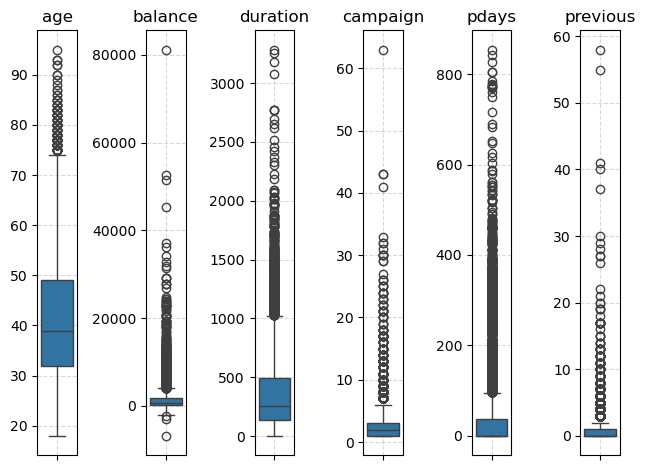

In [68]:
# boxplot cek outlier
plot_boxplot(X_train,X_num)

Seluruh kolom numerik memiliki outlier dengan persentase diatas 1%, tetapi 'pdays' memiliki persentase outlier jauh lebih tinggi (16%) dibanding dengan yang lainnya.

In [69]:
# cek deskriptif
num_desc = check_deskriptif(df,num)

# cek skewness
num_desc[['skewness','jenis_skewness']]

,skewness,jenis_skewness
age,0.862780,skewed
balance,8.224619,skewed
duration,2.143695,skewed
campaign,5.545578,skewed
pdays,2.449986,skewed
previous,7.335298,skewed


Untuk mengatasi outlier, akan dilakukan sensoring menggunakan winsorizer. Perlakukan sensoring setiap kolom akan berbeda-beda tergantung pada skewnessnya.
- Highly skew (skewness > 1): iqr dengan fold 3. --> 'age'.
- Skew biasa (skewness < 1): iqer dengan fold 1.5. --> kolom numerik lain selain 'age'.

In [70]:
# set column sesuai metode caping
## outlier kecil
iqr_fold_15 = ['age']

## outlier extreeme
iqr_fold_3 = X_train[X_num].copy()
# drop yang sudah di assign untuk caping
iqr_fold_3 = iqr_fold_3.drop(columns=['age']).columns.tolist()

# fold 3 untuk extreme outlier
## skew dist capping outlier
# skew dist capping
winsoriser_cap = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=iqr_fold_3)
# fit transform ke train
X_train[iqr_fold_3] = winsoriser_cap.fit_transform(X_train[iqr_fold_3])
# transform ke test
X_test[iqr_fold_3] = winsoriser_cap.transform(X_test[iqr_fold_3])

# fold 1.5 untuk normal outlier
## skew dist capping outlier
winsoriser_cap = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=iqr_fold_15)
# fit transform ke train
X_train[iqr_fold_15] = winsoriser_cap.fit_transform(X_train[iqr_fold_15])
# transform ke test
X_test[iqr_fold_15] = winsoriser_cap.transform(X_test[iqr_fold_15])

In [71]:
#check outlier
check_outlier(X_train,X_num)

,batas_atas,batas_bawah,persentase
age,74.5,6.5,0.0
balance,6410.0,-4594.0,0.0
duration,1557.0,-928.0,0.0
campaign,9.0,-5.0,0.0
pdays,152.0,-114.0,0.0
previous,4.0,-3.0,0.0


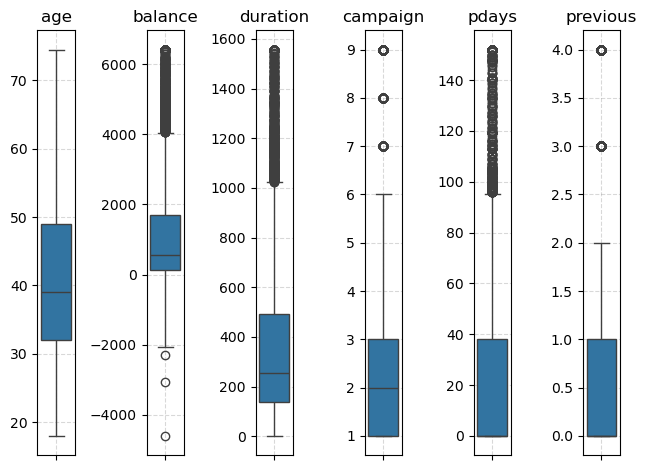

In [72]:
# boxplot cek outlier
plot_boxplot(X_train,X_num)

Setelah dilakukan sensoring, masih terlihat adanya outlier, tetapi tidak sebanyak sebelum dilakukan sensoring. Dari persentase juga sudah terlihat bahwa saat ini data memiliki persentase outlier yang sangat kecil.

In [73]:
# save train & test
X_train_cap = X_train.copy()
X_test_cap  = X_test.copy()
y_test_cap  = y_test.copy()
y_train_cap = y_train.copy()

In [74]:
# Load
X_train = X_train_cap.copy()
X_test  = X_test_cap.copy()
y_test  = y_test_cap.copy()
y_train = y_train_cap.copy()

## Scaling  & Encoding

### Encoding

Komputer hanya bisa membaca angka. Oleh karena itu, dilakukan encoding pada fitur-fitur kategorik dan target.
- Target: Akan dilakukan label encoding dengan mengubah "yes"=1 dan "no"=0.
- 'education': Akan dilakukan ordinal encoding karena terdapat hirarki pada data.
- fitur lainnya selain 'education': Akan dilakukan one-hot encoding karena data tidak memiliki hirarki.

<mark>Notes: Encoding untuk fitur-fitur akan dimasukkan dalam pipeline<mark>

In [75]:
# encode target
y_train['deposit'] = y_train['deposit'].replace({'yes': 1, 'no': 0})
y_test['deposit'] = y_test['deposit'].replace({'yes': 1, 'no': 0})

Kolom target sudah diubah menjadi 0 dan 1.

In [76]:
# save train & test
X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()
y_test_enc  = y_test.copy()
y_train_enc = y_train.copy()

In [77]:
# Load
X_train = X_train_enc.copy()
X_test  = X_test_enc.copy()
y_test  = y_test_enc.copy()
y_train = y_train_enc.copy()

### Scaling

 untuk menyamakan skala dalam data pada fitur-fitur numerik, akan dilakukan scaling.

In [78]:
# check skewness data
num_desc = check_deskriptif(X_train,num)
num_desc[['skewness','jenis_skewness']]

,skewness,jenis_skewness
age,0.728220,skewed
balance,1.708609,skewed
duration,1.590938,skewed
campaign,1.949460,skewed
pdays,1.315819,skewed
previous,1.879385,skewed


Karena data menunjukkan distribusi yang skew dan juga tadi diketahui bahw outliernya sudah relatif sedikit, maka scaling akan dilakukan menggunakan minmax_scaler.

In [79]:
# Scaler
minmaX_scaler = MinMaxScaler()

# loop scaling
for i in num:
    # scaling train
    X_train[num] = minmaX_scaler.fit_transform(X_train[num])
    # scaling test
    X_test[num] = minmaX_scaler.transform(X_test[num])

# hasil
X_train.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,week
8644,0.495575,admin.,married,secondary,no,0.465285,no,yes,cellular,31,jul,0.160129,0.25,0.000000,0.0,unknown,4
2632,0.495575,admin.,married,tertiary,no,0.649400,no,no,cellular,3,sep,0.165916,0.00,0.618421,1.0,success,1


Data numerik sudah memiliki skala yang relatif sama.

In [80]:
# save train & test
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
y_test_scaled  = y_test.copy()
y_train_scaled = y_train.copy()

In [81]:
# Load
X_train = X_train_scaled.copy()
X_test  = X_test_scaled.copy()
y_test  = y_test_scaled.copy()
y_train = y_train_scaled.copy()

## Feature Selection

### Kategorik

Berdasarkan analisis pada EDA, seluruh kolom kategorik berpengaruh terhadap target. Maka seluruh kategorik akan digunakan pada model.

### Numerik

Bedasarkan hasil uji korelasi chi2 pada EDA, diadapatkan bahwa 'age' tidak memiliki korelasi dengan target. Maka, 'age' tidak adakn dipakai pada modeling. Kemudian, telah ada kolom 'week yang dibangun berdasarkan 'day' untuk meminimalisir cardinality, sehingga yang akan digunakan pada model adalah 'week'.

In [82]:
#delete age from train & test
X_train.drop(columns='age',inplace=True)
X_test.drop(columns='age',inplace=True)

'age telah dihilangkan dari data. Untuk 'week' akan dihilangkan/ tidak diikutkan dalam model pada pipeline.

#### Dimensionality Reduction

Dalam rangka mengurangi dimensi pada data, khususnya fitur numerik, akan dilakukan dimensionality reduction. Untuk menentukan berapa banyak informasi yang sebaiknya diambil, perlu dicari tahu penggunakan pca.

In [83]:
# remove age from num list
X_num.remove('age')

# assign pca
pca = PCA(random_state=42)

# fit to data
pca.fit(X_train[X_num])

PCA(random_state=42)

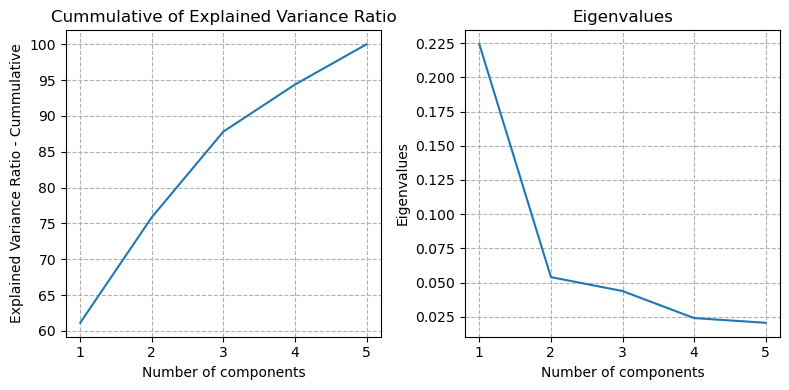

In [84]:
# subplots
fig, ax = plt.subplots(1,2,figsize=(8,4))

# PLOT 1
# Plot the Cummulative of Explained Variance Ratio
ax[0].plot(range(1, 6), np.cumsum(pca.explained_variance_ratio_ * 100))
# add gridline
ax[0].grid(linestyle='--')
# horizontal line 95% data
#ax[0].axhline(y=95, color='red')
# judul plot
ax[0].set_title('Cummulative of Explained Variance Ratio')
# name x label
ax[0].set_xlabel('Number of components')
# name y label
ax[0].set_ylabel('Explained Variance Ratio - Cummulative')

# PLOT 2
# Plot the Eigenvalues
ax[1].plot(range(1, 6), pca.explained_variance_ )
# add gridline
ax[1].grid(linestyle='--')
# add title
ax[1].set_title('Eigenvalues')
# add x label
ax[1].set_xlabel('Number of components')
# add y label
ax[1].set_ylabel('Eigenvalues')

# show plot
plt.tight_layout()
plt.show()

- Dapat dilihat pada Cumulative Explained Ratio, grafik menunjukkan pertumbuhan yang terus menanjak cukup curam, walaupun pada n_components 3 menunjukkan sedikit lebih landai. Namun, grafik tidak dapat ditentukan dengan cukup jelas mengenai berapa komponen yang akan diambil.
- Pada grafik eigenvalue, dapat dilihat bahwa lekukan terjadi pada n_component 2 dan 4 dimana pada n_component 4 dan seterusnya menunjukkan garis yang lebih datar.
Dengan mempertimbangkan kedua grafik di atas, saya akan menggunakan n_components 4.

## Column Transformer

Preprocessing yang akan masuk ke dalam pipeline model adalah:
- numerik: Scaling --> PCA.
- ordinal: Ordinal encode.
- nominal: One-hot encode.

In [85]:
# assign column sesuai perlakuan
# ordinal kolom
ord_col = ['education']
# one-hot kolom
ohe_col = X_cat.copy()
# remove ordinal
ohe_col.remove('education')
# remove day
ohe_col.remove('day')

# scaling kolom
scale_col = X_num.copy()

# Transformer column 1
ct_num = ColumnTransformer([
    ('minmax_scaler', MinMaxScaler(),scale_col)
])

# pipeline ordinal
ord_pipeline = Pipeline([
    ('ord_enc',OrdinalEncoder(categories=[['unknown','primary', 'secondary', 'tertiary']]))
])

# pipeline one-hot
ohe_pipeline = Pipeline([
    ('oh_enc',OneHotEncoder(handle_unknown="ignore"))
])

# pipeline num
pipe_num = Pipeline([
    ('prep_num', ct_num),
    ('pca', PCA(n_components=4,random_state=42))
])

# Transformer Column 2
ct_prep = ColumnTransformer([
    ('numeric', pipe_num, scale_col),
    ('ordinal_encode', ord_pipeline, ord_col),
    ('oh_encode',ohe_pipeline, ohe_col)
])

# check transformer columns
ct_prep


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('prep_num',
                                                  ColumnTransformer(transformers=[('minmax_scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['balance',
                                                                                    'duration',
                                                                                    'campaign',
                                                                                    'pdays',
                                                                                    'previous'])])),
                                                 ('pca',
                                                  PCA(n_components=4,
                                                      random_state=42))]),
                                 ['balance', 'duration', 'campaign', 'pdays',
                                  'previous']),
                                ('ordinal_encode',
                                 Pipeline(steps=[('ord_enc',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'primary',
                                                                              'secondary',
                                                                              'tertiary']]))]),
                                 ['education']),
                                ('oh_encode',
                                 Pipeline(steps=[('oh_enc',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'default', 'housing',
                                  'loan', 'contact', 'month', 'poutcome',
                                  'week'])])

# Model Definition

## KNN

K-Nearest Neighbour adalah algoritma yang menggunakan jarak antar poin unutk melakukan klasifikasi. Kelebihan model ini adalah non-parametrik cocok dengan data berdimensi rendah. Namun, kelemahannya adalah lambatnya prediksi karena perlu menghitung jarak setiap titik dan juga rentan terhadap outlier.

In [86]:
# pipeline model
pipe_knn = Pipeline([
    ('prep', ct_prep),
    ('model', KNeighborsClassifier())
])

# cek pipleline
pipe_knn

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('prep_num',
                                                                   ColumnTransformer(transformers=[('minmax_scaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['balance',
                                                                                                     'duration',
                                                                                                     'campaign',
                                                                                                     'pdays',
                                                                                                     'previous'])])),
                                                                  ('pca',
                                                                   PCA(n_components=4,
                                                                       random_state=42))]),
                                                  ['balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('ordinal_encode',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'primary',
                                                                                               'secondary',
                                                                                               'tertiary']]))]),
                                                  ['education']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'week'])])),
                ('model', KNeighborsClassifier())])

## SVM

SVM adalah algoritma yang bekerja dengan cara mencari hyperplane yang paling optimal untuk mengklasifikasikan data. Kelebihannya adalah cocok untuk data berdimensi tinggi dan robust terhadap overfitting. Adanya pilihan kernel membuatnya lebih fleksibel.

In [87]:
# pipeline model
pipe_svm = Pipeline([
    ('prep', ct_prep),
    ('model', SVC(random_state=42))
])

# cek
pipe_svm

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('prep_num',
                                                                   ColumnTransformer(transformers=[('minmax_scaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['balance',
                                                                                                     'duration',
                                                                                                     'campaign',
                                                                                                     'pdays',
                                                                                                     'previous'])])),
                                                                  ('pca',
                                                                   PCA(n_components=4,
                                                                       random_state=42))]),
                                                  ['balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('ordinal_encode',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'primary',
                                                                                               'secondary',
                                                                                               'tertiary']]))]),
                                                  ['education']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'week'])])),
                ('model', SVC(random_state=42))])

## Decision Tree
Model yang membentuk pohon beserta daunnya sebanyak yang ditentukan/ sebanyak data.

In [88]:
# pipeline model
pipe_dt = Pipeline([
    ('prep', ct_prep),
    ('model', DecisionTreeClassifier(random_state=42))
])

# cek
pipe_dt

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('prep_num',
                                                                   ColumnTransformer(transformers=[('minmax_scaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['balance',
                                                                                                     'duration',
                                                                                                     'campaign',
                                                                                                     'pdays',
                                                                                                     'previous'])])),
                                                                  ('pca',
                                                                   PCA(n_components=4,
                                                                       random_state=42))]),
                                                  ['balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('ordinal_encode',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'primary',
                                                                                               'secondary',
                                                                                               'tertiary']]))]),
                                                  ['education']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'week'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

## Random Forest
Model yang terbentuk dari kumpulan decision tree.

In [89]:
# pipeline model
pipe_rf = Pipeline([
    ('prep', ct_prep),
    ('model', RandomForestClassifier(random_state=42))
])

# cek
pipe_rf

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('prep_num',
                                                                   ColumnTransformer(transformers=[('minmax_scaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['balance',
                                                                                                     'duration',
                                                                                                     'campaign',
                                                                                                     'pdays',
                                                                                                     'previous'])])),
                                                                  ('pca',
                                                                   PCA(n_components=4,
                                                                       random_state=42))]),
                                                  ['balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('ordinal_encode',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'primary',
                                                                                               'secondary',
                                                                                               'tertiary']]))]),
                                                  ['education']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'week'])])),
                ('model', RandomForestClassifier(random_state=42))])

## Gradient Boosting
Model yang membangun pohon secara bertahap untuk memperbaiki kesalahan prediksi model sebelumnya.

In [90]:
# pipeline model
pipe_boost = Pipeline([
    ('prep', ct_prep),
    ('model', GradientBoostingClassifier(random_state=42))
])

# cek
pipe_boost

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('prep_num',
                                                                   ColumnTransformer(transformers=[('minmax_scaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['balance',
                                                                                                     'duration',
                                                                                                     'campaign',
                                                                                                     'pdays',
                                                                                                     'previous'])])),
                                                                  ('pca',
                                                                   PCA(n_components=4,
                                                                       random_state=42))]),
                                                  ['balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('ordinal_encode',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'primary',
                                                                                               'secondary',
                                                                                               'tertiary']]))]),
                                                  ['education']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'week'])])),
                ('model', GradientBoostingClassifier(random_state=42))])

# Model Training

In [91]:
# Load
X_train = X_train_enc.copy()
X_test  = X_test_enc.copy()
y_test  = y_test_enc.copy()
y_train = y_train_enc.copy()

In [92]:
# Training KNN
pipe_knn.fit(X_train, y_train)

# Training SVM
pipe_svm.fit(X_train, y_train)

# Training decision tree
pipe_dt.fit(X_train, y_train)

# Training random forest
pipe_rf.fit(X_train, y_train)

# Training KNN
pipe_boost.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('prep_num',
                                                                   ColumnTransformer(transformers=[('minmax_scaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['balance',
                                                                                                     'duration',
                                                                                                     'campaign',
                                                                                                     'pdays',
                                                                                                     'previous'])])),
                                                                  ('pca',
                                                                   PCA(n_components=4,
                                                                       random_state=42))]),
                                                  ['balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('ordinal_encode',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'primary',
                                                                                               'secondary',
                                                                                               'tertiary']]))]),
                                                  ['education']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'week'])])),
                ('model', GradientBoostingClassifier(random_state=42))])

# Model Evaluation

In [93]:
# crossval knn
knn_train_cross_val = cross_val_score(pipe_knn,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision")

# crossval svm
svm_train_cross_val = cross_val_score(pipe_svm,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision")

# crossval dt
dt_train_cross_val = cross_val_score(pipe_dt,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision")

# crossval rf
rf_train_cross_val = cross_val_score(pipe_rf,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision")

# crossval boost
boost_train_cross_val = cross_val_score(pipe_boost,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision")

In [94]:
# predict knn
y_pred_train_knn = pipe_knn.predict(X_train)
y_pred_test_knn = pipe_knn.predict(X_test)

# predict svm
y_pred_train_svm = pipe_svm.predict(X_train)
y_pred_test_svm = pipe_knn.predict(X_test)

# predict dt
y_pred_train_dt = pipe_dt.predict(X_train)
y_pred_test_dt = pipe_knn.predict(X_test)

# predict rf
y_pred_train_rf = pipe_rf.predict(X_train)
y_pred_test_rf = pipe_knn.predict(X_test)

# predict boosting
y_pred_train_boost = pipe_boost.predict(X_train)
y_pred_test_boost = pipe_knn.predict(X_test)

# menyimpan report
all_reports = {}

# knn report
all_reports = performance_report(all_reports,knn_train_cross_val, y_train, y_pred_train_knn, y_test, y_pred_test_knn, 'KNN Baseline (Default Hyperparameter)')
# svm report
all_reports = performance_report(all_reports,svm_train_cross_val, y_train, y_pred_train_svm, y_test, y_pred_test_svm, 'SVM Baseline (Default Hyperparameter)')
# dt report
all_reports = performance_report(all_reports,dt_train_cross_val, y_train, y_pred_train_dt, y_test, y_pred_test_dt, 'DT Baseline (Default Hyperparameter)')
# rf report
all_reports = performance_report(all_reports,rf_train_cross_val, y_train, y_pred_train_rf, y_test, y_pred_test_rf, 'RF Baseline (Default Hyperparameter)')
# boost report
all_reports = performance_report(all_reports,boost_train_cross_val, y_train, y_pred_train_boost, y_test, y_pred_test_boost, 'BOOST Baseline (Default Hyperparameter)')

# to df
pd.DataFrame(all_reports)

,KNN Baseline (Default Hyperparameter),SVM Baseline (Default Hyperparameter),DT Baseline (Default Hyperparameter),RF Baseline (Default Hyperparameter),BOOST Baseline (Default Hyperparameter)
train - precision,0.844864,0.849599,1.000000,1.000000,0.823383
train - precision - cv,0.755272,0.831818,0.750344,0.807869,0.810048
train - accuracy,0.820921,0.858327,1.000000,1.000000,0.845223
test - precision,0.748352,0.748352,0.748352,0.748352,0.748352
test - accuracy_score,0.728616,0.728616,0.728616,0.728616,0.728616


model Baseline terbaik adalah KNN karena walaupun memiliki train yang lebih rendah, namun selisih overfit dengan test lebih dekat.

# Hyperparameter Tuning

In [95]:
# melihat parameter pipeline
pipe_knn.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('prep_num',
                                                     ColumnTransformer(transformers=[('minmax_scaler',
                                                                                      MinMaxScaler(),
                                                                                      ['balance',
                                                                                       'duration',
                                                                                       'campaign',
                                                                                       'pdays',
                                                                                       'previous'])])),
                                                    ('pca',
                                                     PCA(n_components=4,
                    

In [96]:
# Random grid hyperparameters for KNN
random_grid = {
    'model__n_neighbors': np.arange(1, 31),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': np.arange(10, 50, 5),
    'model__p': [1, 2]
}

# Inisiasi RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipe_knn, 
                                   param_distributions=random_grid, 
                                   n_iter=100, 
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='precision')

# fitting 
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('prep_num',
                                                                                                ColumnTransformer(transformers=[('minmax_scaler',
                                                                                                                                 MinMaxScaler(),
                                                                                                                                 ['balance',
                                                                                                                                  'duration',
                                                                                                                                  'campaign',
                                                                                                                                  'pdays',
                                                                                                                                  'previous'])])),
                                                                                               ('pca',
                                                                                                PCA(n_components=4,
                                                                                                    random_state=42))]),
                                                                               ['balance',
                                                                                'duration',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous']),...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                                        'model__leaf_size': array([10, 15, 20, 25, 30, 35, 40, 45]),
                                        'model__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'model__p': [1, 2],
                                        'model__weights': ['uniform',
                                                           'distance']},
                   random_state=42, scoring='precision', verbose=2)

In [97]:
# Output the best parameters and the best precision score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best precision score: {random_search.best_score_}")

Best parameters: {'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 26, 'model__leaf_size': 35, 'model__algorithm': 'ball_tree'}
Best precision score: 0.8159579473820588


Parameter terbaik yang didapat adalah:
- 'model__weights': 'uniform', 
- 'model__p': 1, 
- 'model__n_neighbors': 26, 
- 'model__leaf_size': 35, 
- 'model__algorithm': 'ball_tree'

Precision Score - Test Set   :  0.7918367346938775 

Classification Report : 
               precision    recall  f1-score   support

           0       0.63      0.92      0.75      4698
           1       0.82      0.40      0.54      4231

    accuracy                           0.67      8929
   macro avg       0.73      0.66      0.64      8929
weighted avg       0.72      0.67      0.65      8929
 

Confusion Matrix      : 


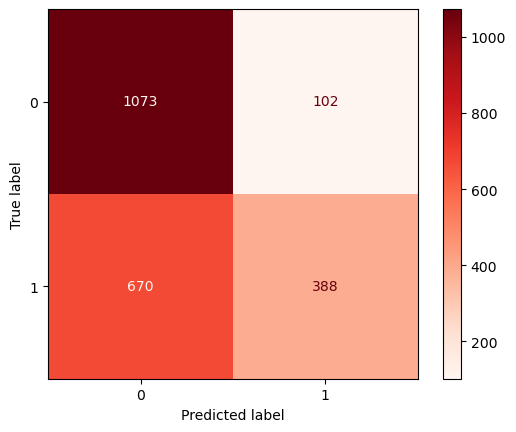

In [98]:
# Get Best Estimator
random_search_best = random_search.best_estimator_

# Check Performance Model
y_pred_test = random_search_best.predict(X_test_scaled)
y_pred_train = random_search_best.predict(X_train_scaled)


print('Precision Score - Test Set   : ', precision_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(random_search_best, X_test_scaled, y_test, cmap='Reds'))

Model memiliki performa yang jauh lebih baik setelah dilakukan tuning, tetapi masih sedikit overfit.

# Model Saving

In [99]:
# save model
with open('knn_best.pkl','wb') as file_1:
    pickle.dump(random_search_best, file_1)

# Kesimpulan

Diantara model-model yang dicoba, KNN memiliki baseline terbaik sehingga KNN dilakukan hyperparameter tuning dan menghasilkan performa 82% yang mana cukup baik. Artinya, model dapat memprediksi 82% data dengan benar.

1. Bagging dan Cara Kerjanya: Bagging adalah teknik ensemble yang mengurangi varians dengan melatih model pada subset data berbeda secara paralel, lalu menggabungkan hasilnya melalui voting atau averaging untuk prediksi akhir.
2. Perbedaan Random Forest dengan Gradient Boosting: Random Forest menggunakan bagging untuk melatih pohon keputusan secara paralel pada subset data berbeda, sedangkan Gradient Boosting membangun pohon secara bertahap untuk memperbaiki kesalahan prediksi model sebelumnya.
3. Cross Validation: Cross Validation adalah teknik evaluasi model dengan membagi data menjadi beberapa subset (folds), melatih model pada sebagian data, dan memvalidasi pada fold lain untuk mendapatkan estimasi kinerja yang lebih akurat.

# Rekomendasi

Tim marketing dapat memanfaatkan hal ini untuk lebih menyebar jala kepada: 
- nasabah dengan pekerjaan pelajar, pensiunan, belum bekerja, dan manajemen.
- status single
- pendidikan tertiary
- tidak memiliki load, default, housing
- succcess poutcome
- minggu 1-2